In [1]:
%load_ext autoreload
%autoreload 2
from eden.util import configure_logging
import logging
configure_logging(logging.getLogger(),verbosity=2)
%matplotlib inline
!pwd

/home/ikea/GraphLearn/example


In [2]:
# get data
from eden.converter.graph.gspan import gspan_to_eden
from itertools import islice


def clean(graphs):
    for g in graphs:
        for n,d in g.nodes(data=True):
            d.pop('weight')
        yield g

def get_graphs(dataset_fname='../toolsdata/bursi.pos.gspan', size=100):
    return  islice(gspan_to_eden(dataset_fname),size)


#dataset_names = !cat NCI60/names
#dataset = dataset_names[4]
#dataset_fname = 'NCI60/' + dataset + '_orig_pos.gspan'
#print 'Working with dataset: %s' % dataset 


In [3]:
'''DEBUGGING PREPROCESSA'''
from graphlearn.utils import draw
import graphlearn.abstract_graphs.score_based as sb
from eden.graph import Vectorizer

v=Vectorizer(triangular_decomposition=False,complexity=3)
pp=sb.PreProcessor()
gm=pp.fit_transform(get_graphs(size=100),v)



fitting was asked with n=1

Classifier:
SGDClassifier(alpha=0.000957258685411, average=False, class_weight=None,
       epsilon=0.1, eta0=0.455191590117, fit_intercept=True, l1_ratio=0.15,
       learning_rate='invscaling', loss='log', n_iter=57, n_jobs=1,
       penalty='elasticnet', power_t=0.195457194759, random_state=None,
       shuffle=True, verbose=0, warm_start=False)

Predictive performance:
            accuracy: 1.000 +- 0.000
           precision: 1.000 +- 0.000
              recall: 1.000 +- 0.000
                  f1: 1.000 +- 0.000
   average_precision: 1.000 +- 0.000
             roc_auc: 1.000 +- 0.000


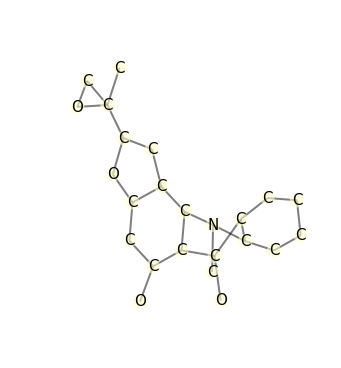

24


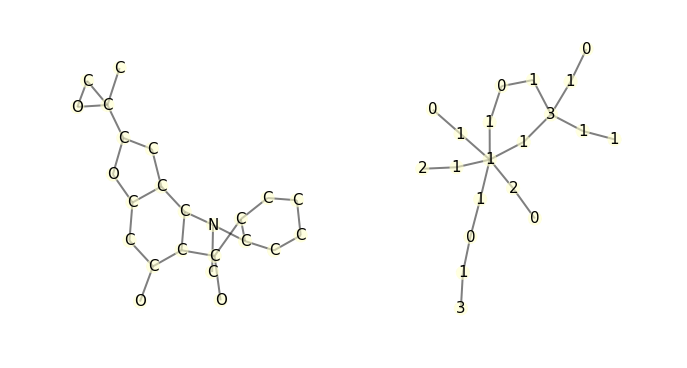

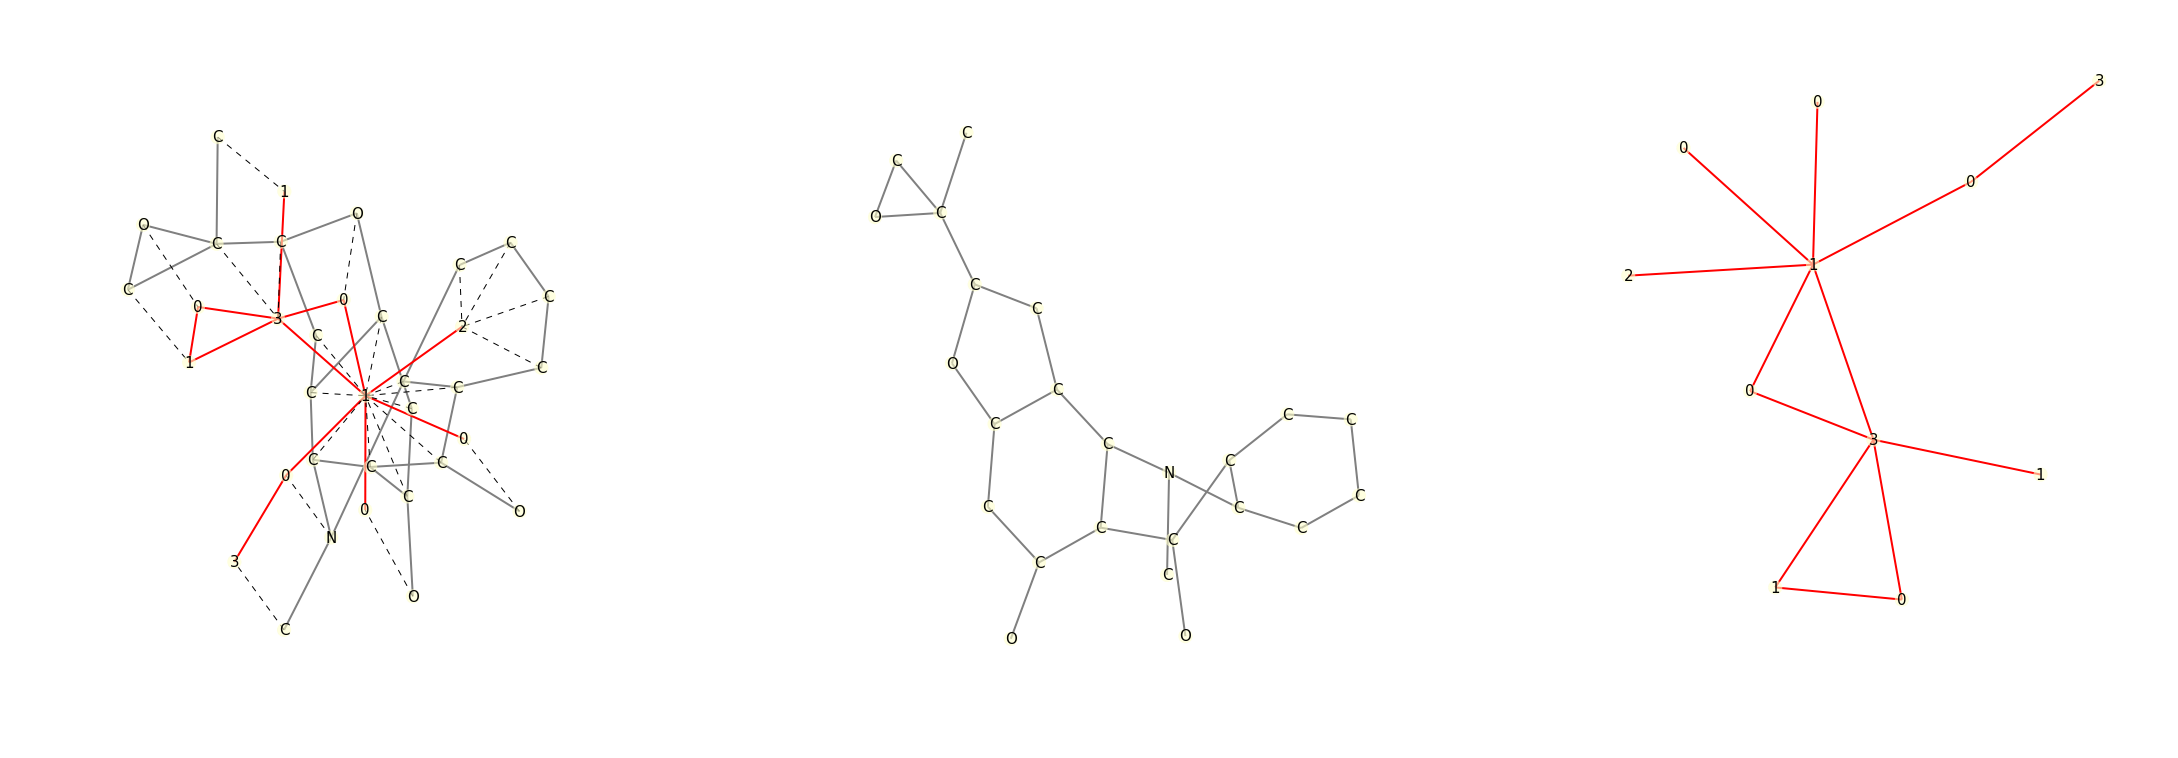

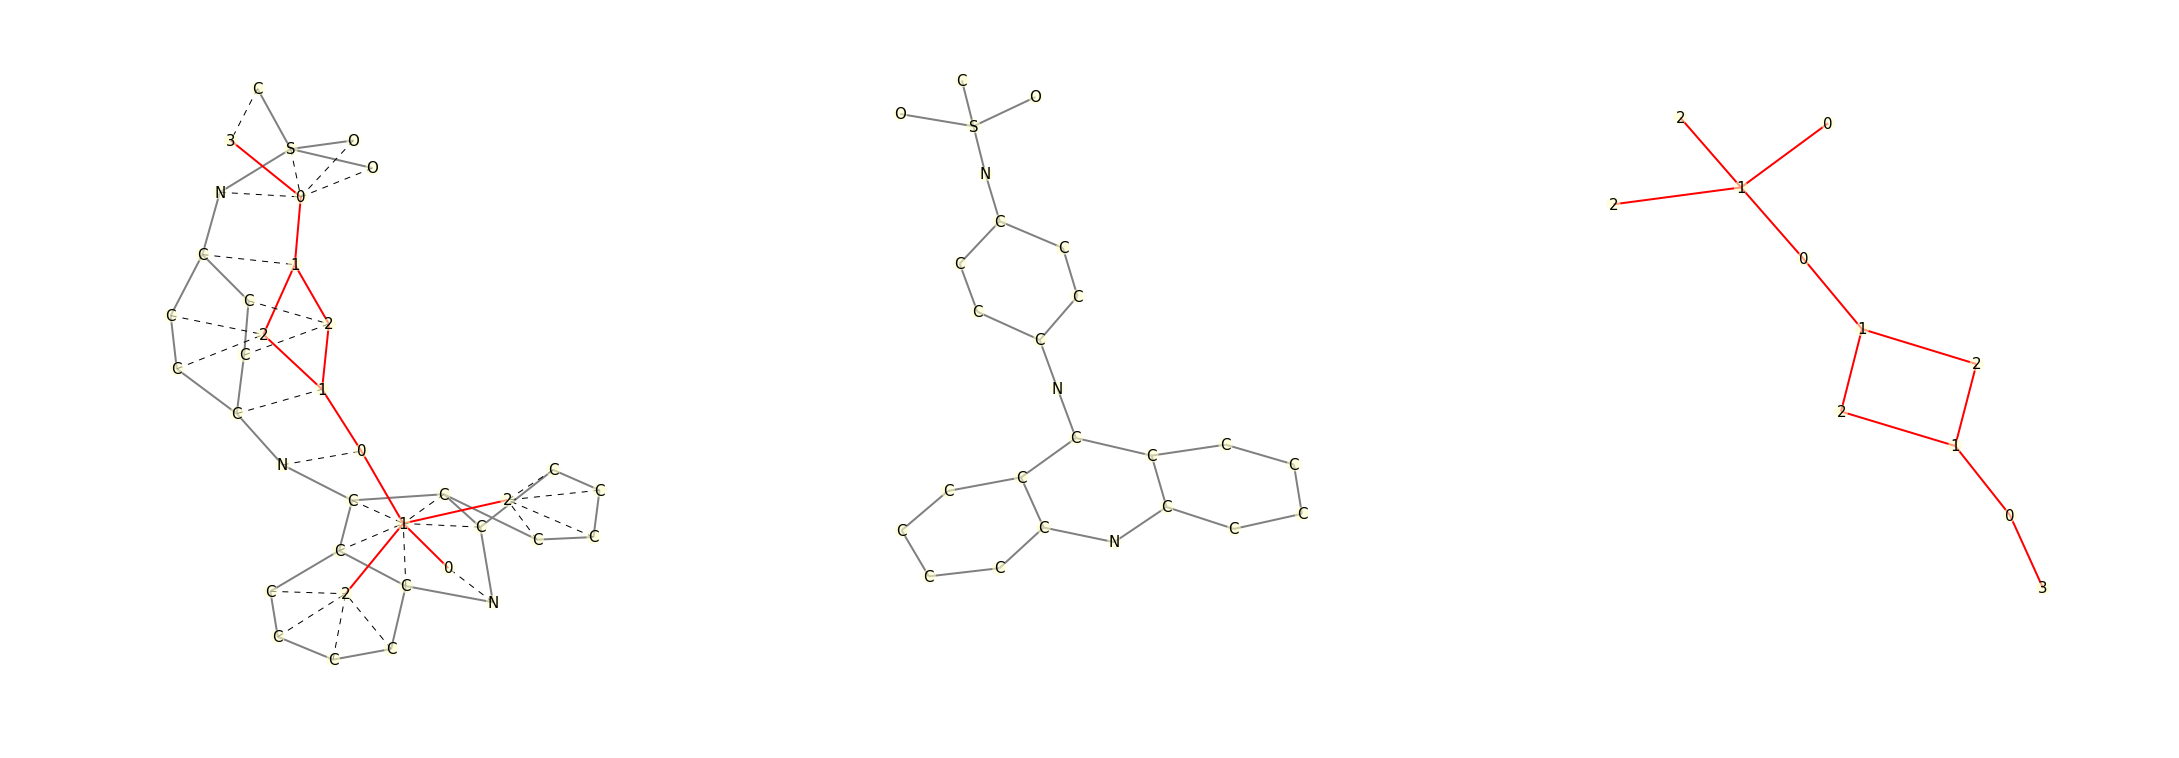

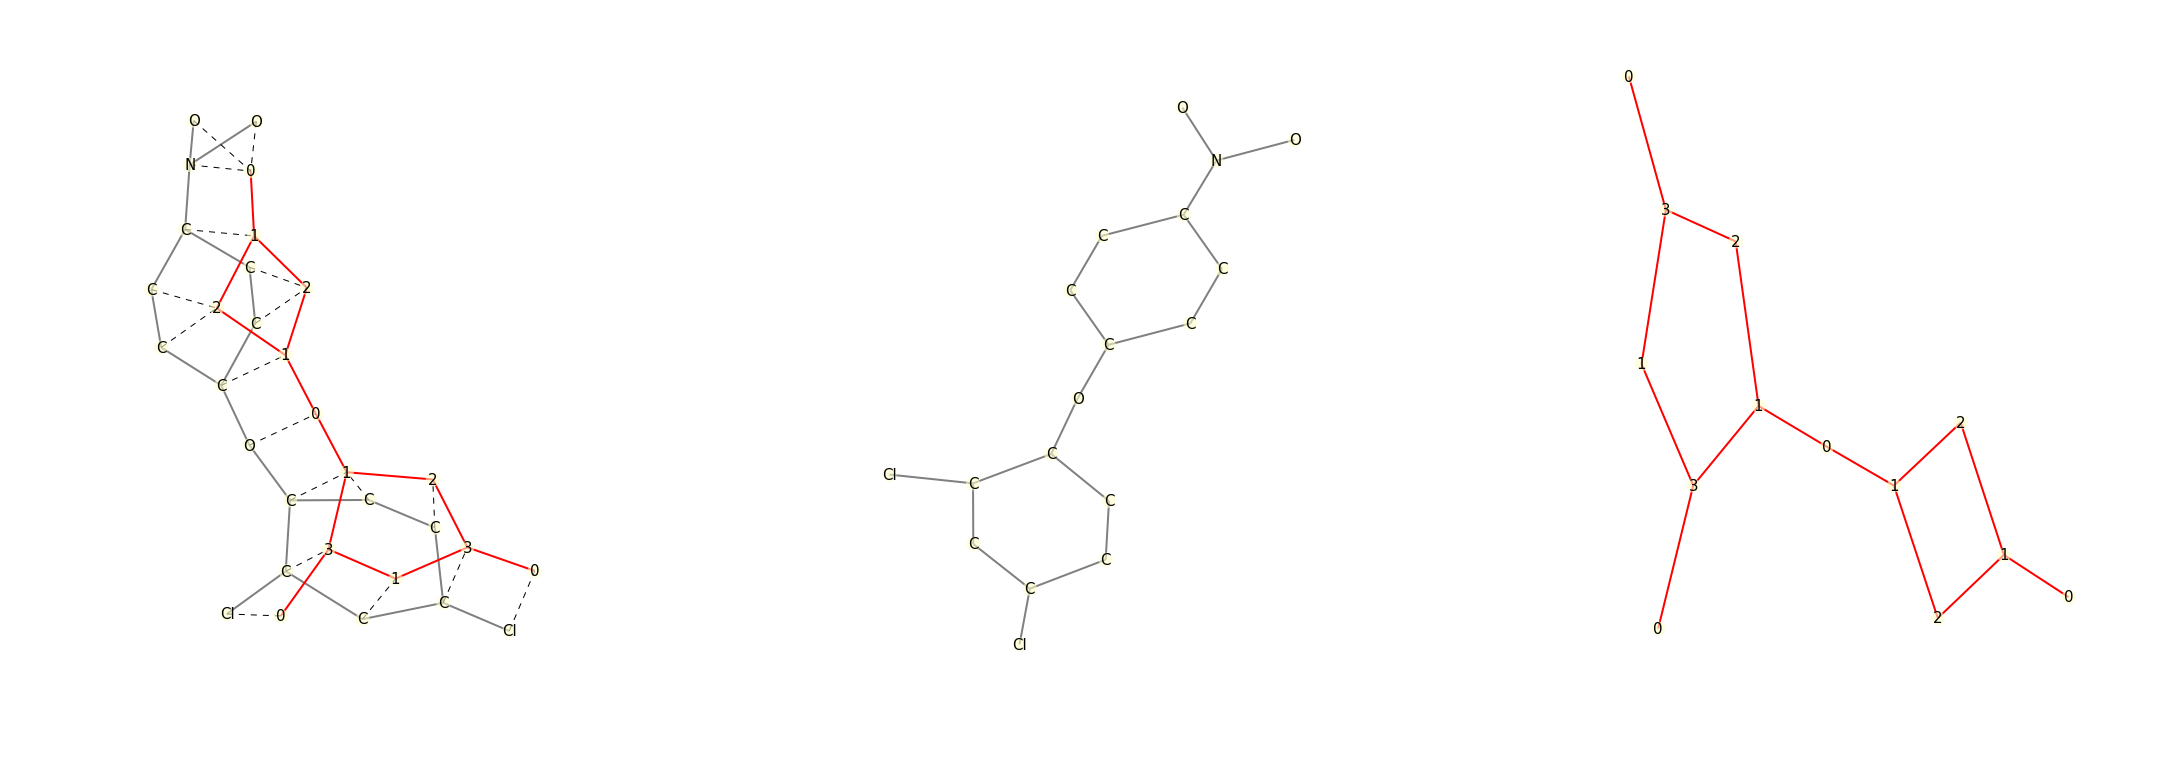

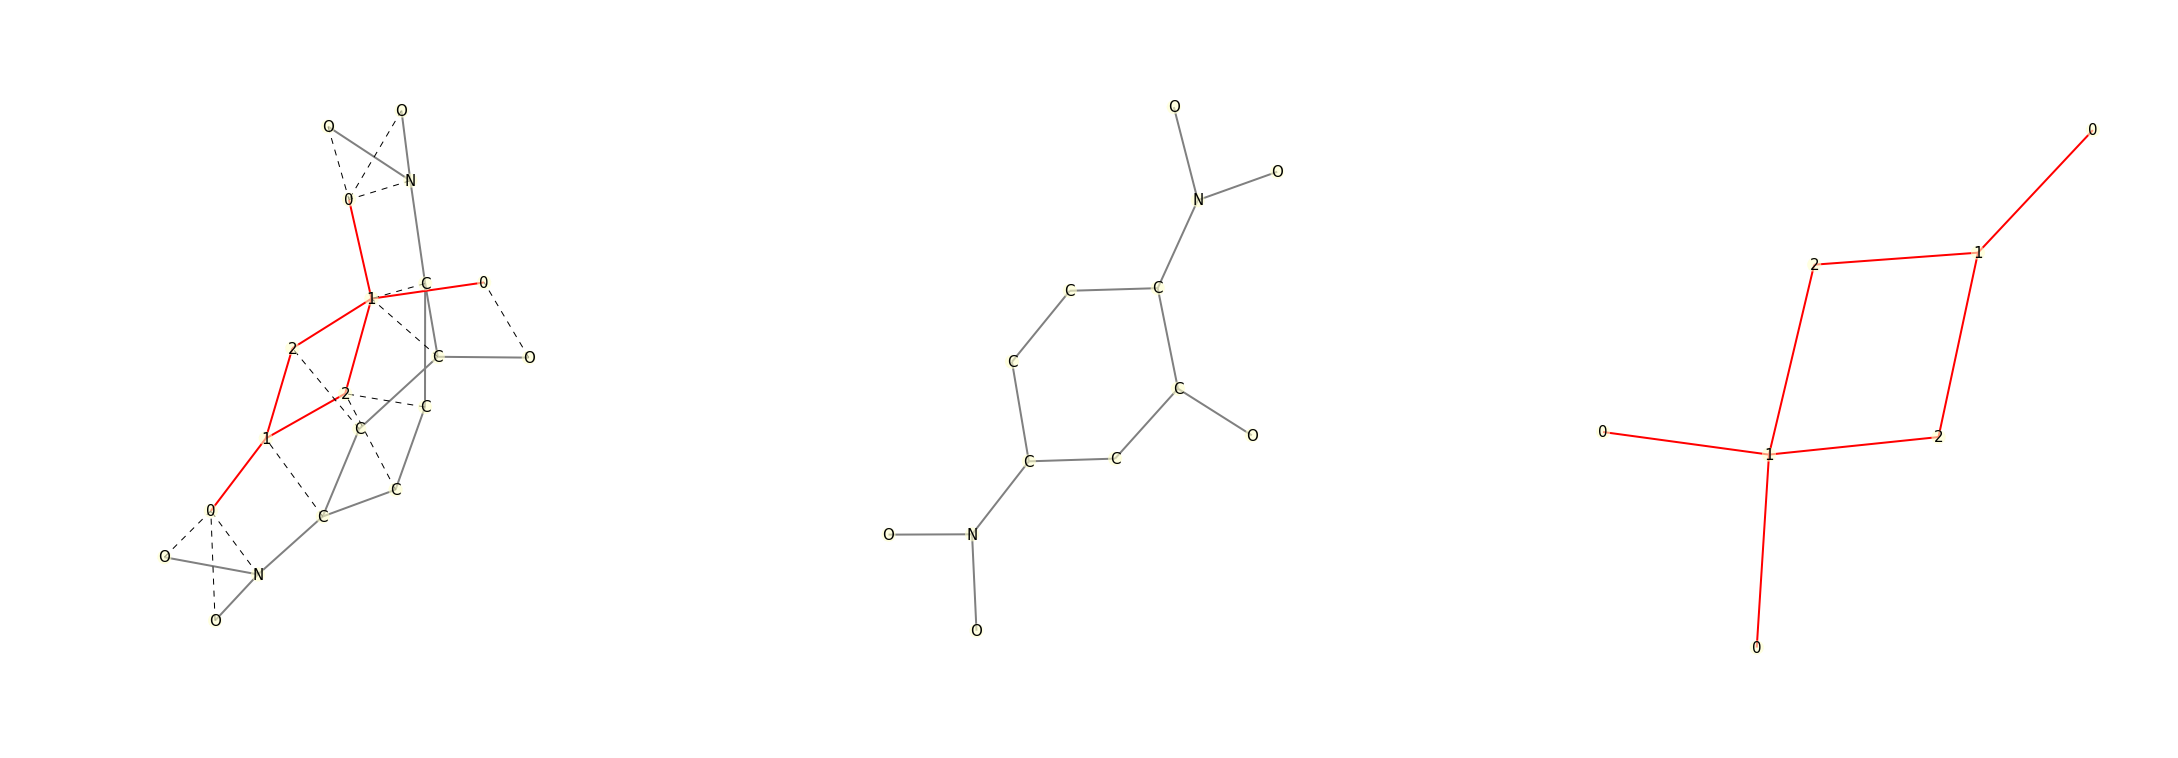

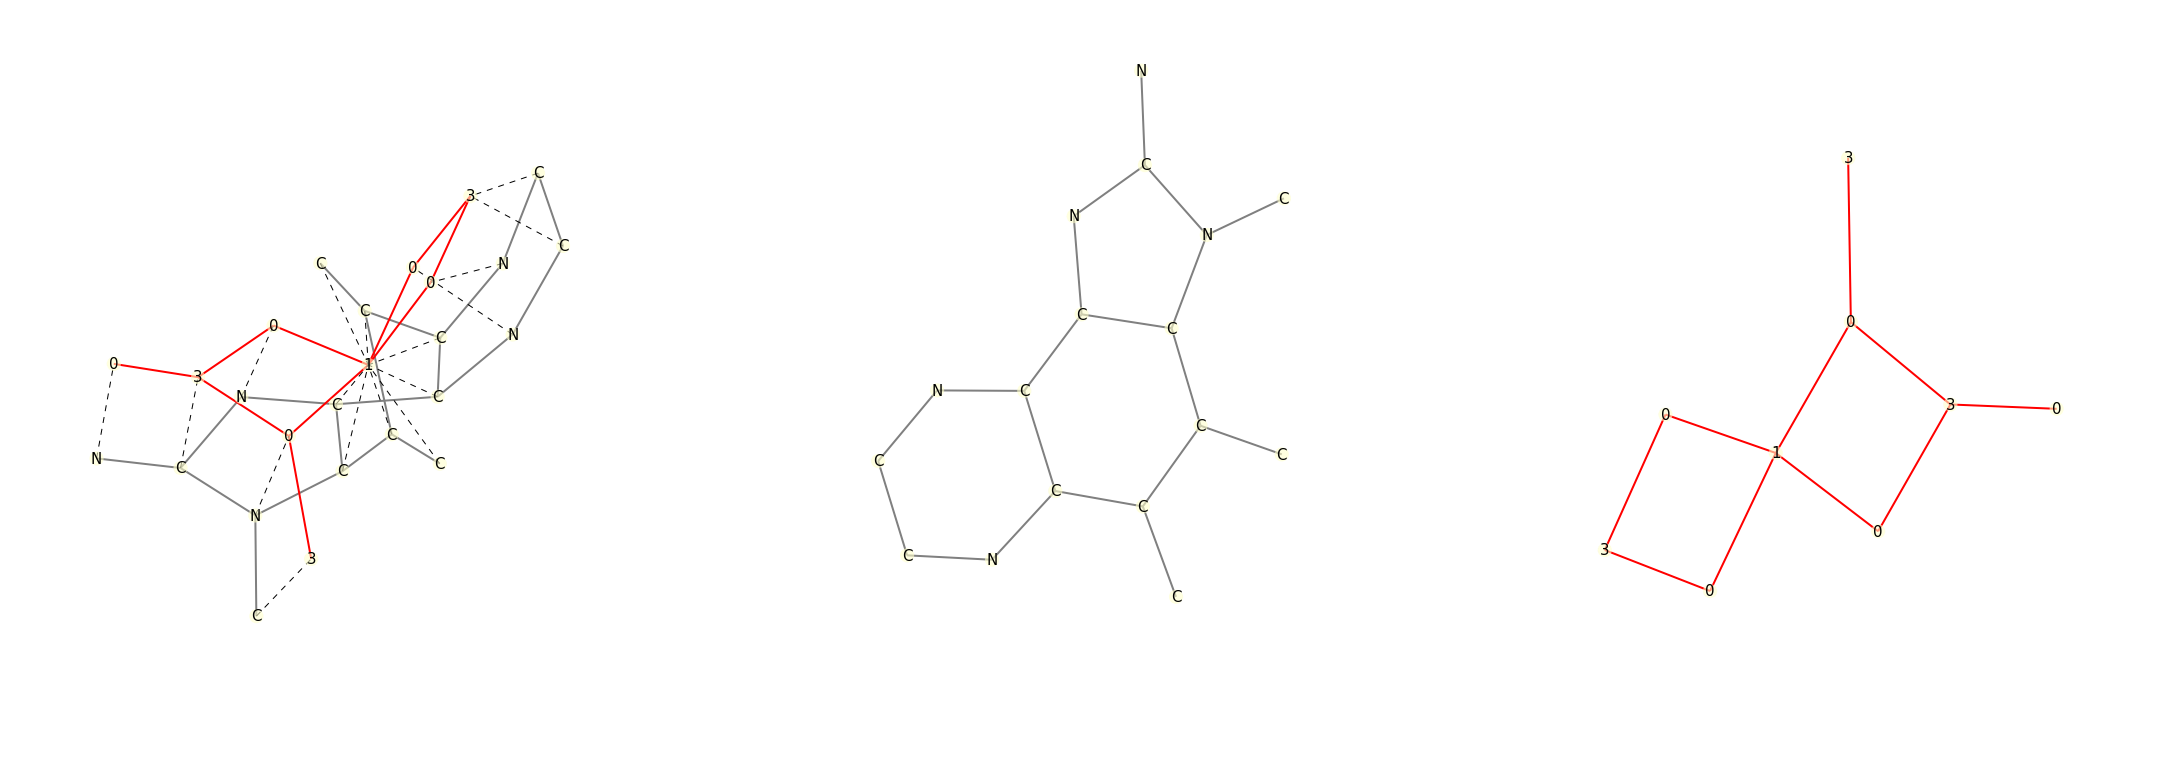

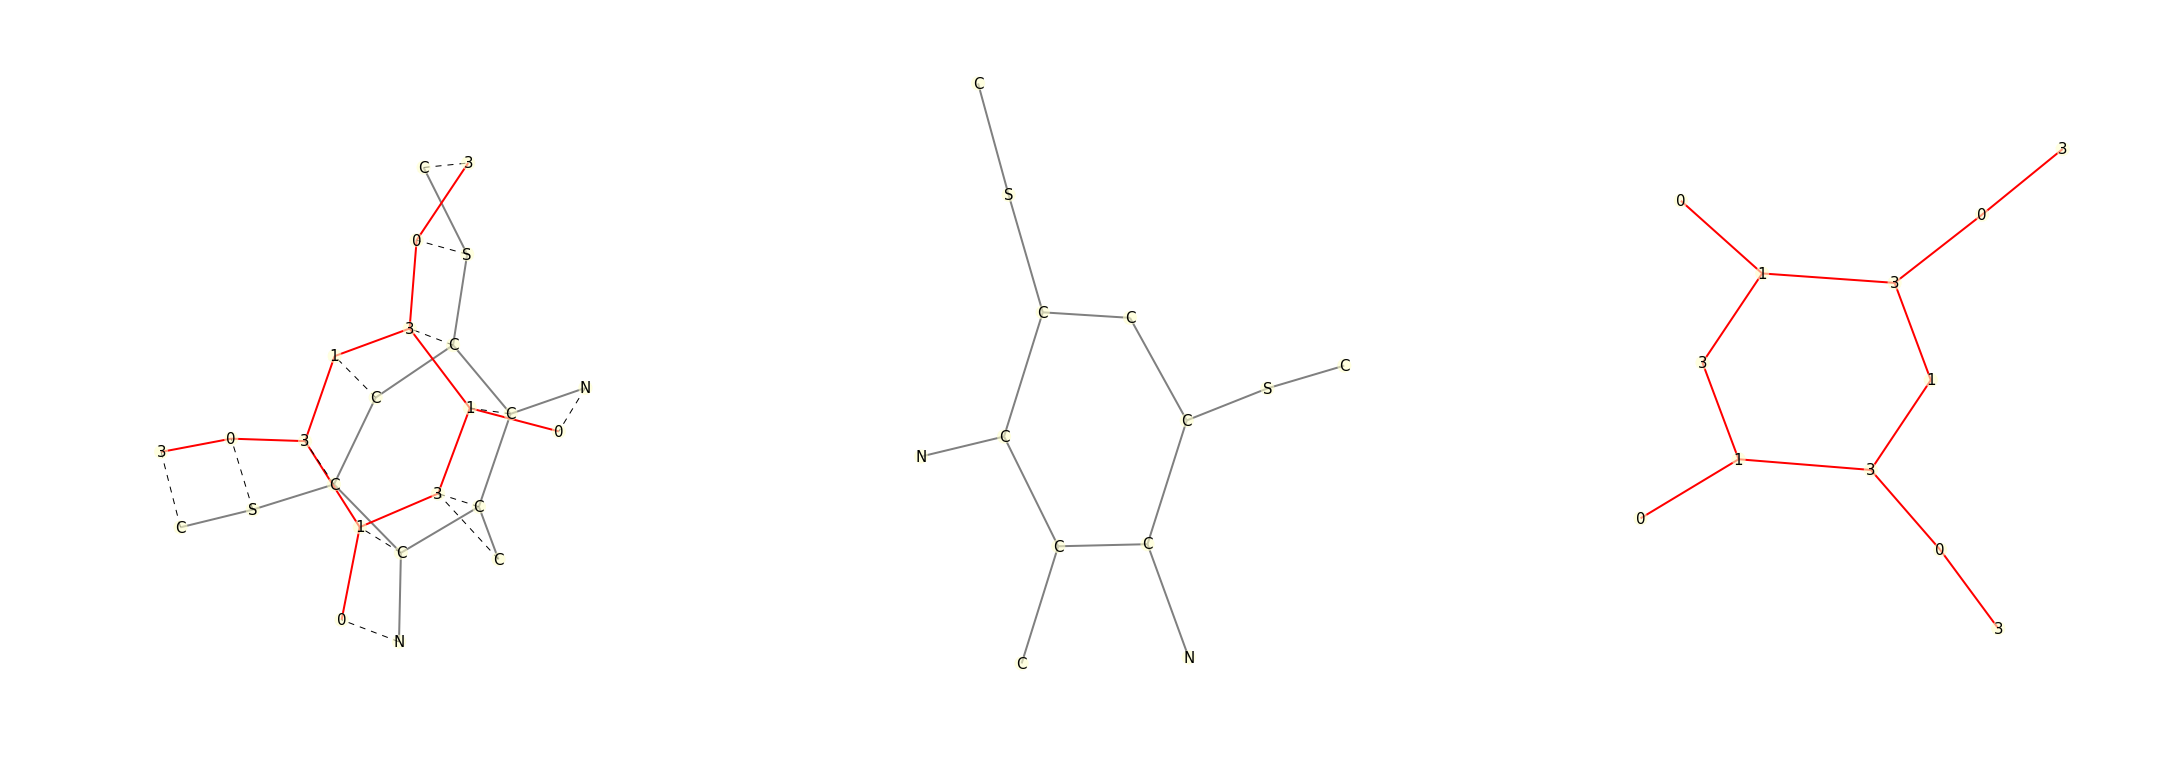

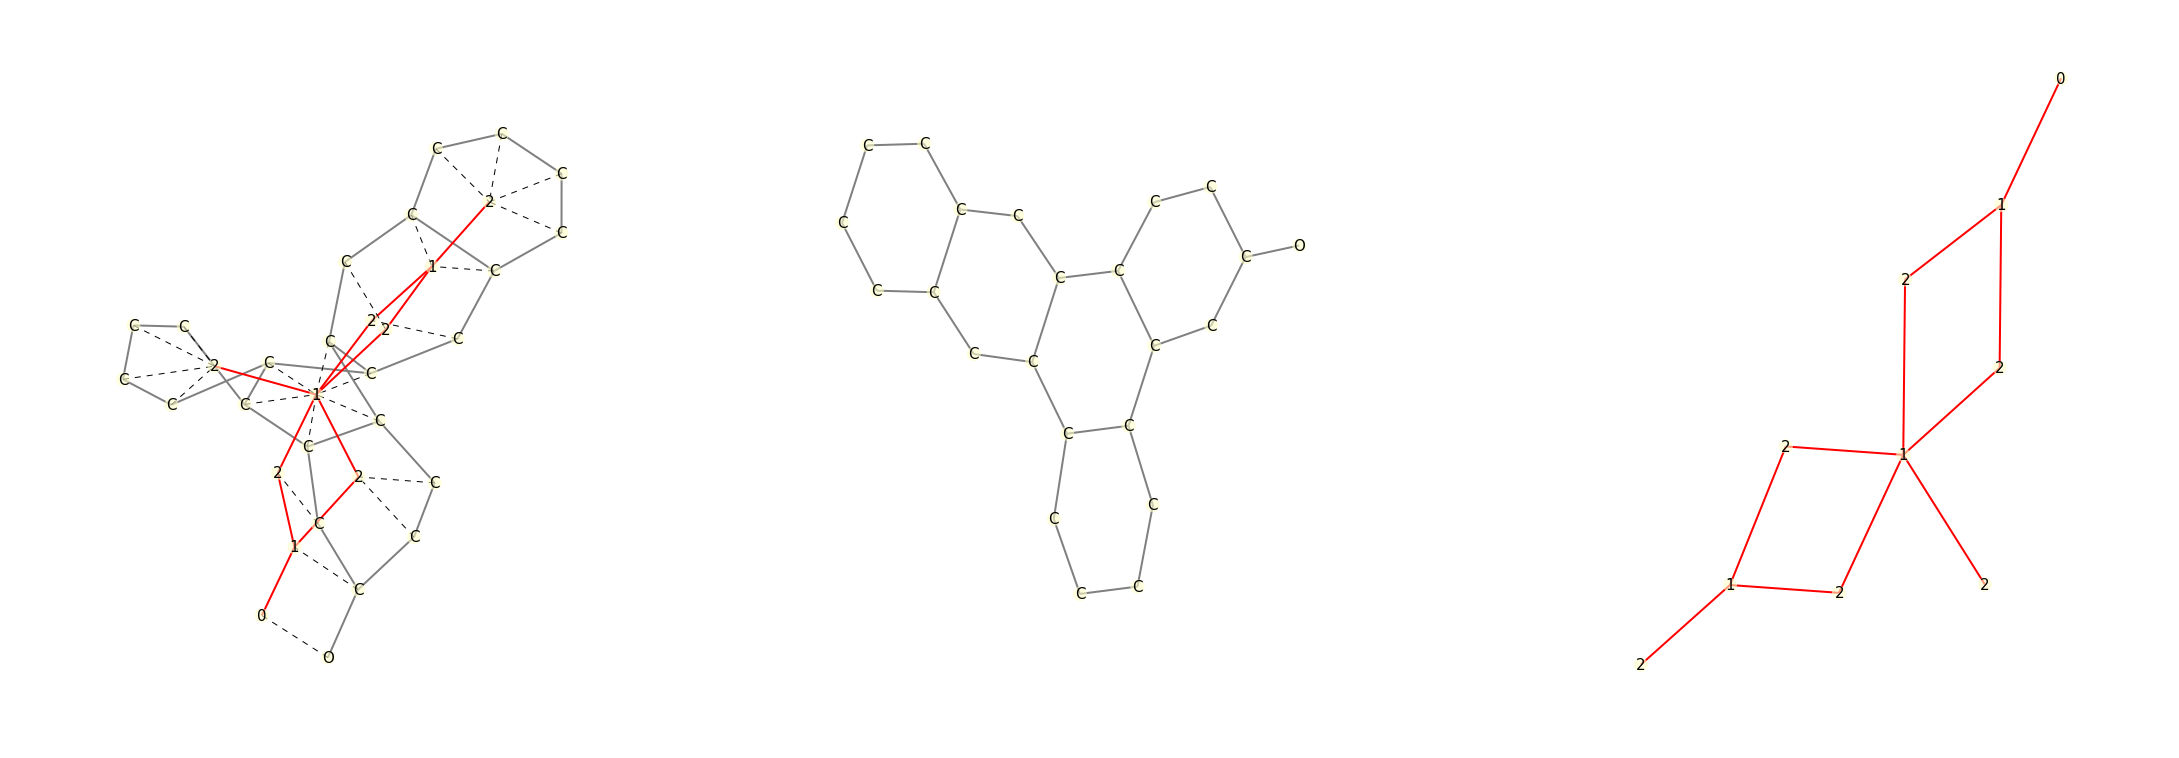

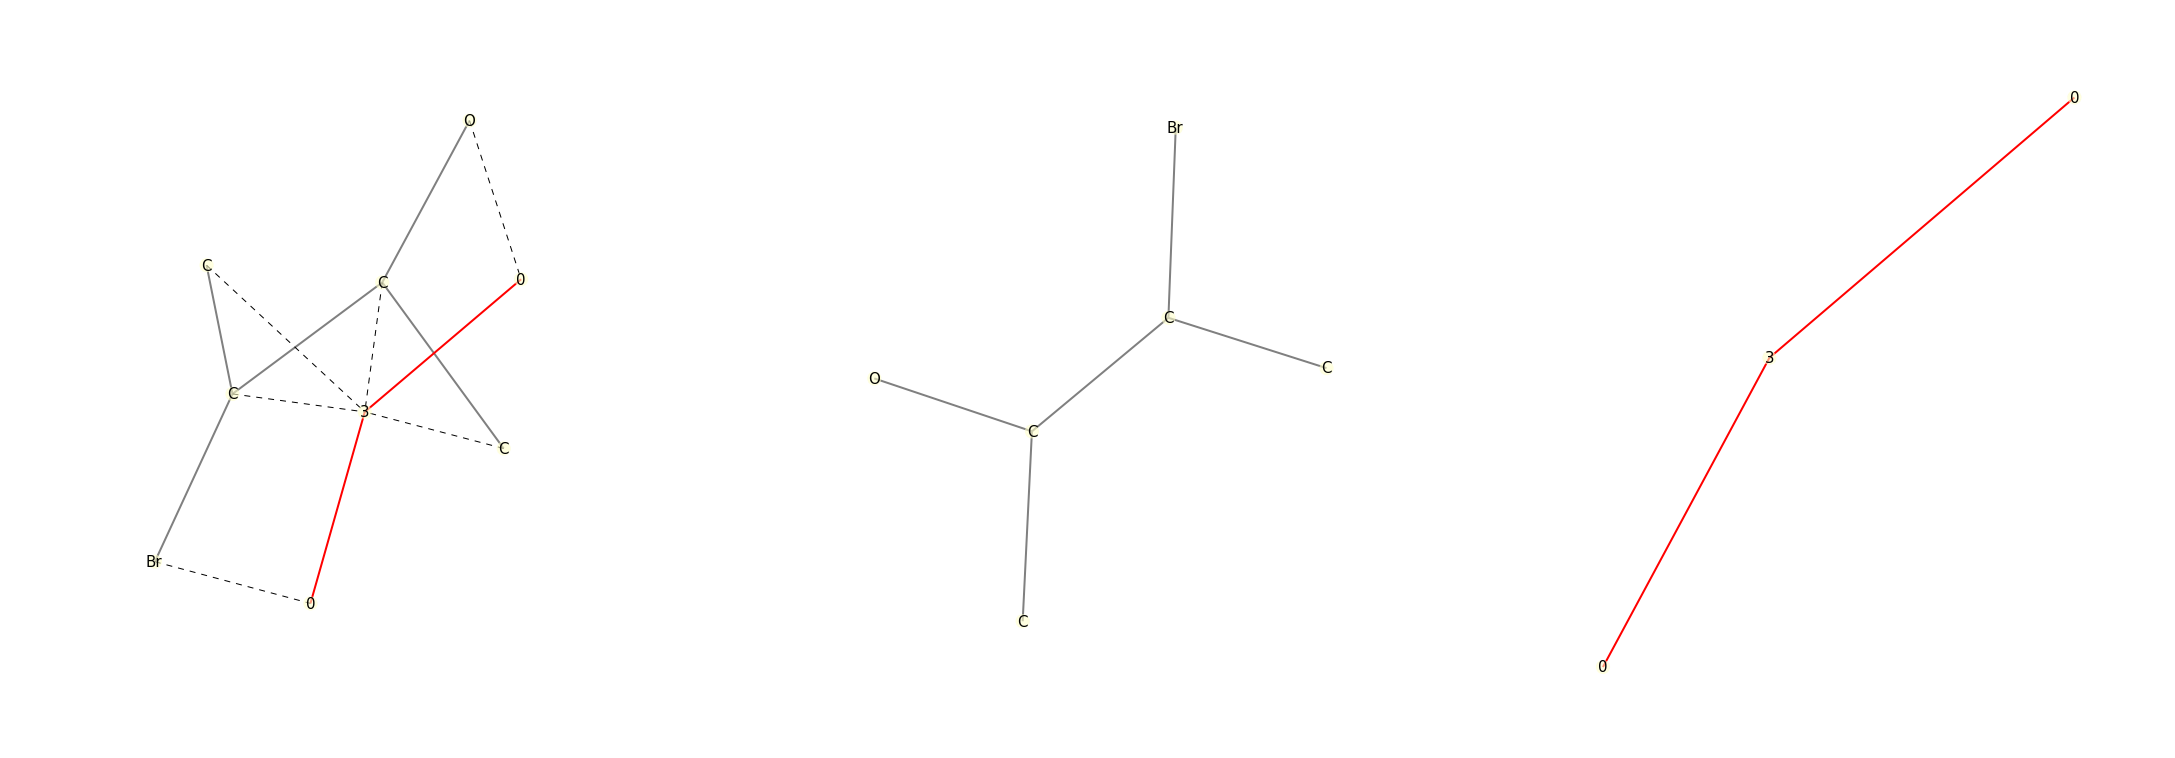

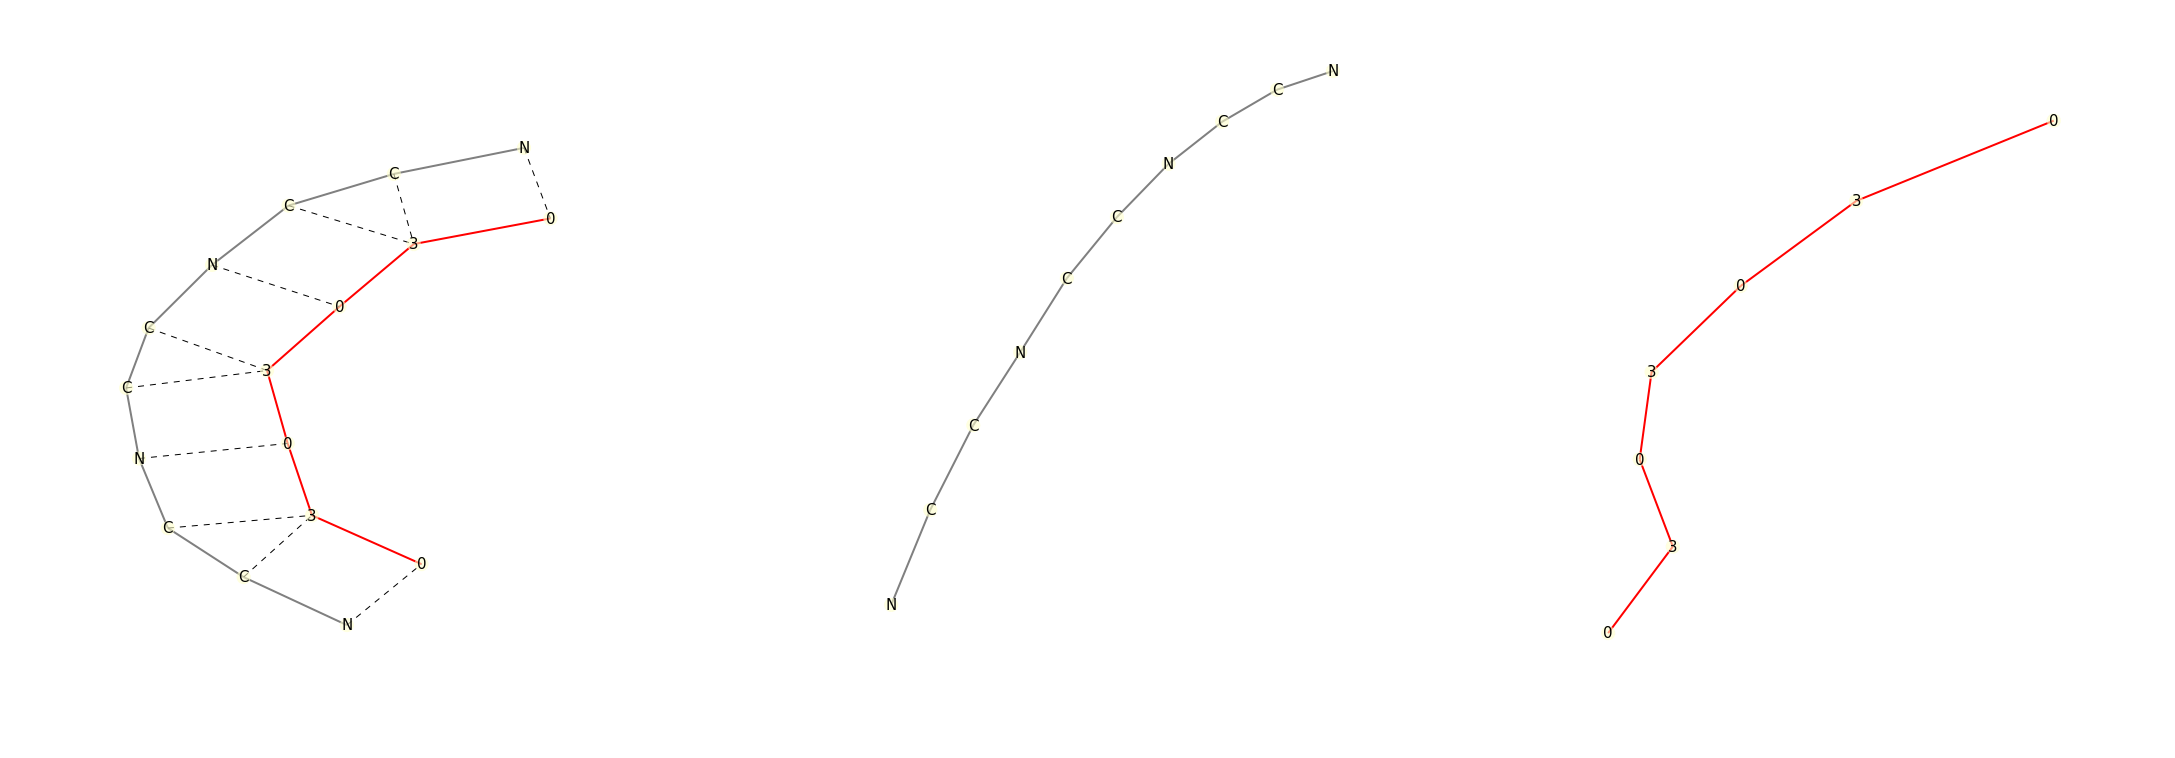

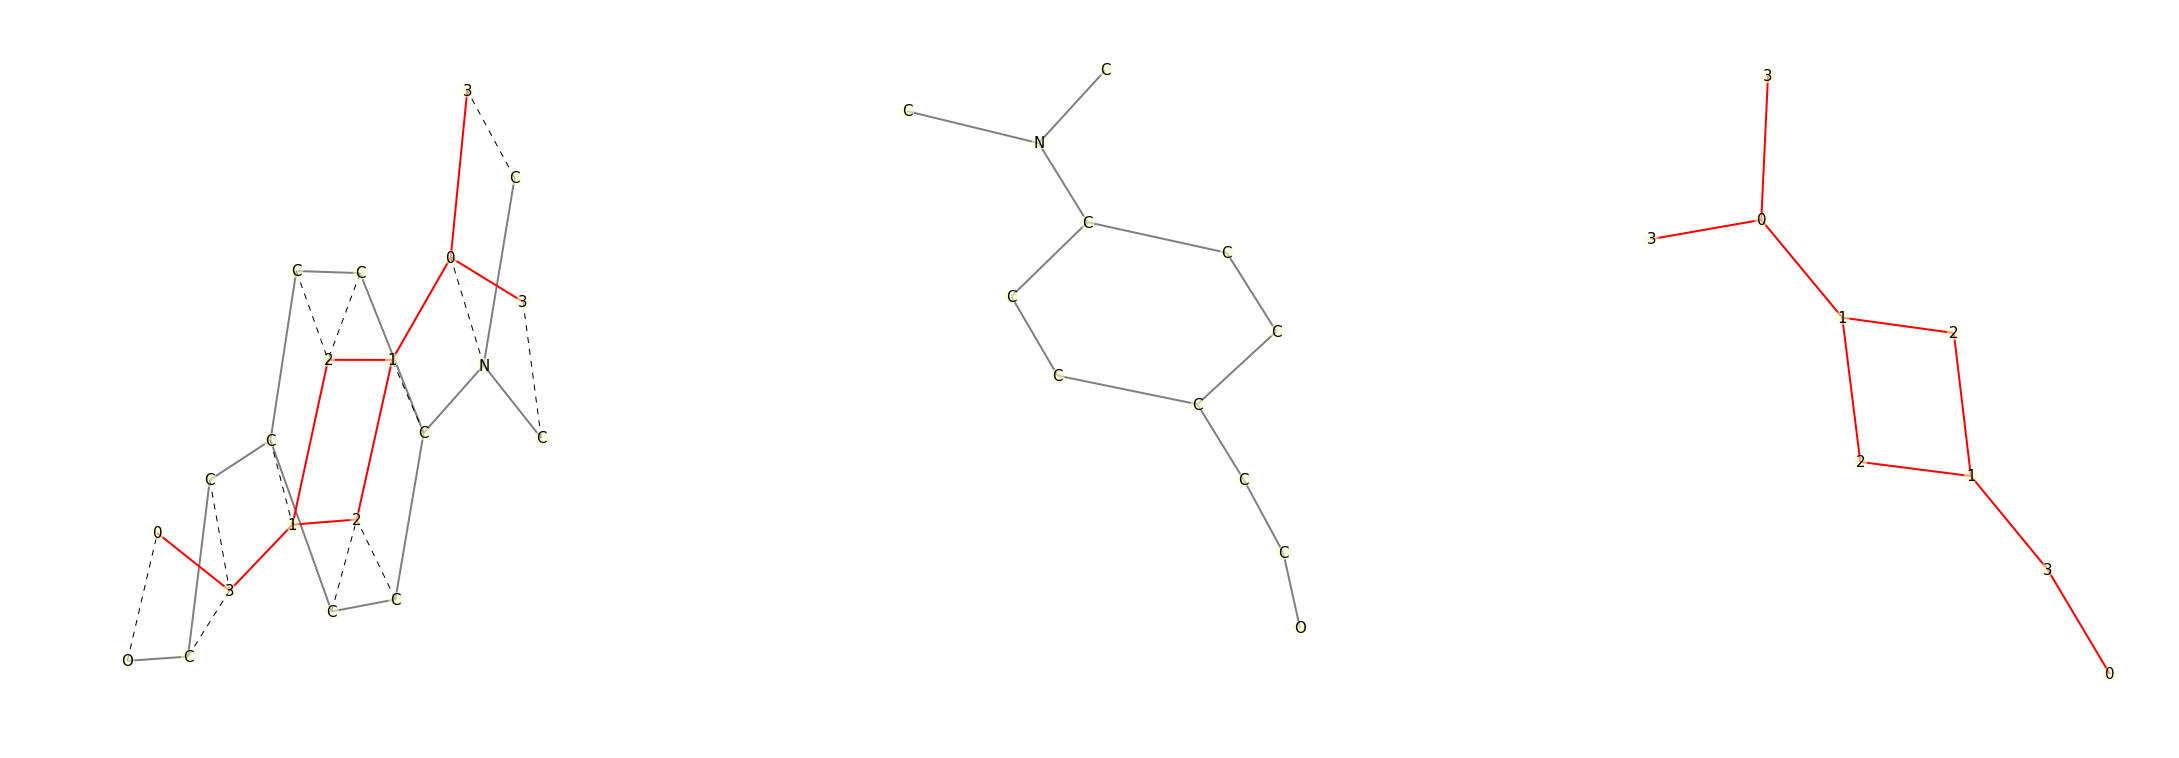

In [4]:

from graphlearn.utils import draw

gr = [i for i in get_graphs(size=10)]
pp.re_transform_single(gr[5])

for i in range(10):
    draw.graphlearn([gm[i+5].graph(),gm[i+5].base_graph(),gm[i+5].abstract_graph()],size=13,contract=True, abstract_color='red')


In [5]:
""" ITS NOT BROKEN SO THERE IS NO NEED TO FIX :)))


'''TESTING EXTRACTION AND GRAPHMANAGER'''
from graphlearn.utils import draw
import graphlearn.abstract_graphs.score_based as sb
from graphlearn.graphlearn import GraphLearnSampler as GLS
from eden.graph import Vectorizer

vectorizer=Vectorizer()

print 'DEMONSTRATING GRAPH MANAGER'
graphs=get_graphs()

for i in range(2):
    print 'grammar example %d' % i
    g=graphs.next()
    gm=mole.MolecularGraphWrapper(g,vectorizer,base_thickness_list=[2])
    #g=gm.graph(nested=True)
    #print g.nodes(data=True)
    #g.node[0].pop('weight')
    #vec=vectorizer.transform_single(g)
    draw.graphlearn([gm.graph(nested=True),gm.abstract_graph(),gm.base_graph()], size = 15,vertex_label = 'label',contract=False)

    
print 'DEMONSTRATING EXTRACTION'  
radius_list=[0,2]
thickness_list=[2,4]
base_thickness_list=[2]
argz=(gm,radius_list,thickness_list,Vectorizer(),2**20-1,lambda x,y:True, base_thickness_list)

cips=gm.all_core_interface_pairs(thickness_list=[2],radius_list=[0,1],hash_bitmask=2**20-1)
draw.graphlearn(cips[0][0].graph, contract=False)


g=gm.graph(nested=False)
print 'test', g.nodes(data=True)[0][1]
#g.node[0].pop('weight')
vec=vectorizer.transform_single(g)
"""

" ITS NOT BROKEN SO THERE IS NO NEED TO FIX :)))\n\n\n'''TESTING EXTRACTION AND GRAPHMANAGER'''\nfrom graphlearn.utils import draw\nimport graphlearn.abstract_graphs.score_based as sb\nfrom graphlearn.graphlearn import GraphLearnSampler as GLS\nfrom eden.graph import Vectorizer\n\nvectorizer=Vectorizer()\n\nprint 'DEMONSTRATING GRAPH MANAGER'\ngraphs=get_graphs()\n\nfor i in range(2):\n    print 'grammar example %d' % i\n    g=graphs.next()\n    gm=mole.MolecularGraphWrapper(g,vectorizer,base_thickness_list=[2])\n    #g=gm.graph(nested=True)\n    #print g.nodes(data=True)\n    #g.node[0].pop('weight')\n    #vec=vectorizer.transform_single(g)\n    draw.graphlearn([gm.graph(nested=True),gm.abstract_graph(),gm.base_graph()], size = 15,vertex_label = 'label',contract=False)\n\n    \nprint 'DEMONSTRATING EXTRACTION'  \nradius_list=[0,2]\nthickness_list=[2,4]\nbase_thickness_list=[2]\nargz=(gm,radius_list,thickness_list,Vectorizer(),2**20-1,lambda x,y:True, base_thickness_list)\n\ncips=gm.al

In [6]:
%%time
'''
learning a grammar, DEBUGGER

import graphlearn.abstract_graphs.score_based as sb
from graphlearn.graphlearn import GraphLearnSampler as GLS

graphs = get_graphs(size=100)
sampler=GLS(radius_list=[0,1],thickness_list=[1], min_cip_count=2, min_interface_count=2, preprocessor=sb.PreProcessor(base_thickness_list=[2]))


graphmanagers= sampler.preprocessor.fit_transform(graphs,sampler.vectorizer)
#sampler.fit(graphs,n_jobs=1,batch_size=1)


print sampler.preprocessor.kmeans.predict(3.0)[0]
#draw.graphlearn(graphmanagers[0].graph())
#sampler.estimatorobject.fit(graphmanagers, vectorizer=sampler.vectorizer, nu=.5,   n_jobs=1)
'''

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 300 µs


'\nlearning a grammar, DEBUGGER\n\nimport graphlearn.abstract_graphs.score_based as sb\nfrom graphlearn.graphlearn import GraphLearnSampler as GLS\n\ngraphs = get_graphs(size=100)\nsampler=GLS(radius_list=[0,1],thickness_list=[1], min_cip_count=2, min_interface_count=2, preprocessor=sb.PreProcessor(base_thickness_list=[2]))\n\n\ngraphmanagers= sampler.preprocessor.fit_transform(graphs,sampler.vectorizer)\n#sampler.fit(graphs,n_jobs=1,batch_size=1)\n\n\nprint sampler.preprocessor.kmeans.predict(3.0)[0]\n#draw.graphlearn(graphmanagers[0].graph())\n#sampler.estimatorobject.fit(graphmanagers, vectorizer=sampler.vectorizer, nu=.5,   n_jobs=1)\n'

In [7]:
%%time
'''
learning a grammar
'''
import graphlearn.abstract_graphs.score_based as sb
from graphlearn.graphlearn import GraphLearnSampler as GLS
graphs = get_graphs(size=1200)
sampler=GLS(radius_list=[0,1],thickness_list=[1], min_cip_count=2, min_interface_count=2, preprocessor=sb.PreProcessor(base_thickness_list=[2]))

sampler.fit(graphs,n_jobs=1,batch_size=1)

sampler.save('tmp/mole_ubergrammar.ge')




fitting was asked with n=1

Classifier:
SGDClassifier(alpha=0.000989096599288, average=False, class_weight=None,
       epsilon=0.1, eta0=0.214156963949, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', n_iter=66, n_jobs=1,
       penalty='l2', power_t=0.743067362319, random_state=None,
       shuffle=True, verbose=0, warm_start=False)

Predictive performance:
            accuracy: 1.000 +- 0.000
           precision: 1.000 +- 0.000
              recall: 1.000 +- 0.000
                  f1: 1.000 +- 0.000
   average_precision: 1.000 +- 0.000
             roc_auc: 1.000 +- 0.000
fitting was asked with n=1

Classifier:
SGDClassifier(alpha=0.000687424805205, average=False, class_weight=None,
       epsilon=0.1, eta0=0.904211637894, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', n_iter=72, n_jobs=1,
       penalty='l2', power_t=0.314816353088, random_state=None,
       shuffle=True, verbose=0, warm_start=False)

Predictive perfo

/home/ikea/.local/lib/python2.7/site-packages/sklearn/calibration.py:398: RuntimeWarning: overflow encountered in exp
  E = np.exp(AB[0] * F + AB[1])
/home/ikea/.local/lib/python2.7/site-packages/sklearn/calibration.py:408: RuntimeWarning: overflow encountered in exp
  E = np.exp(AB[0] * F + AB[1])
/home/ikea/.local/lib/python2.7/site-packages/sklearn/calibration.py:410: RuntimeWarning: invalid value encountered in multiply
  TEP_minus_T1P = P * (T * E - T1)


interface id: 427728 [97 options]


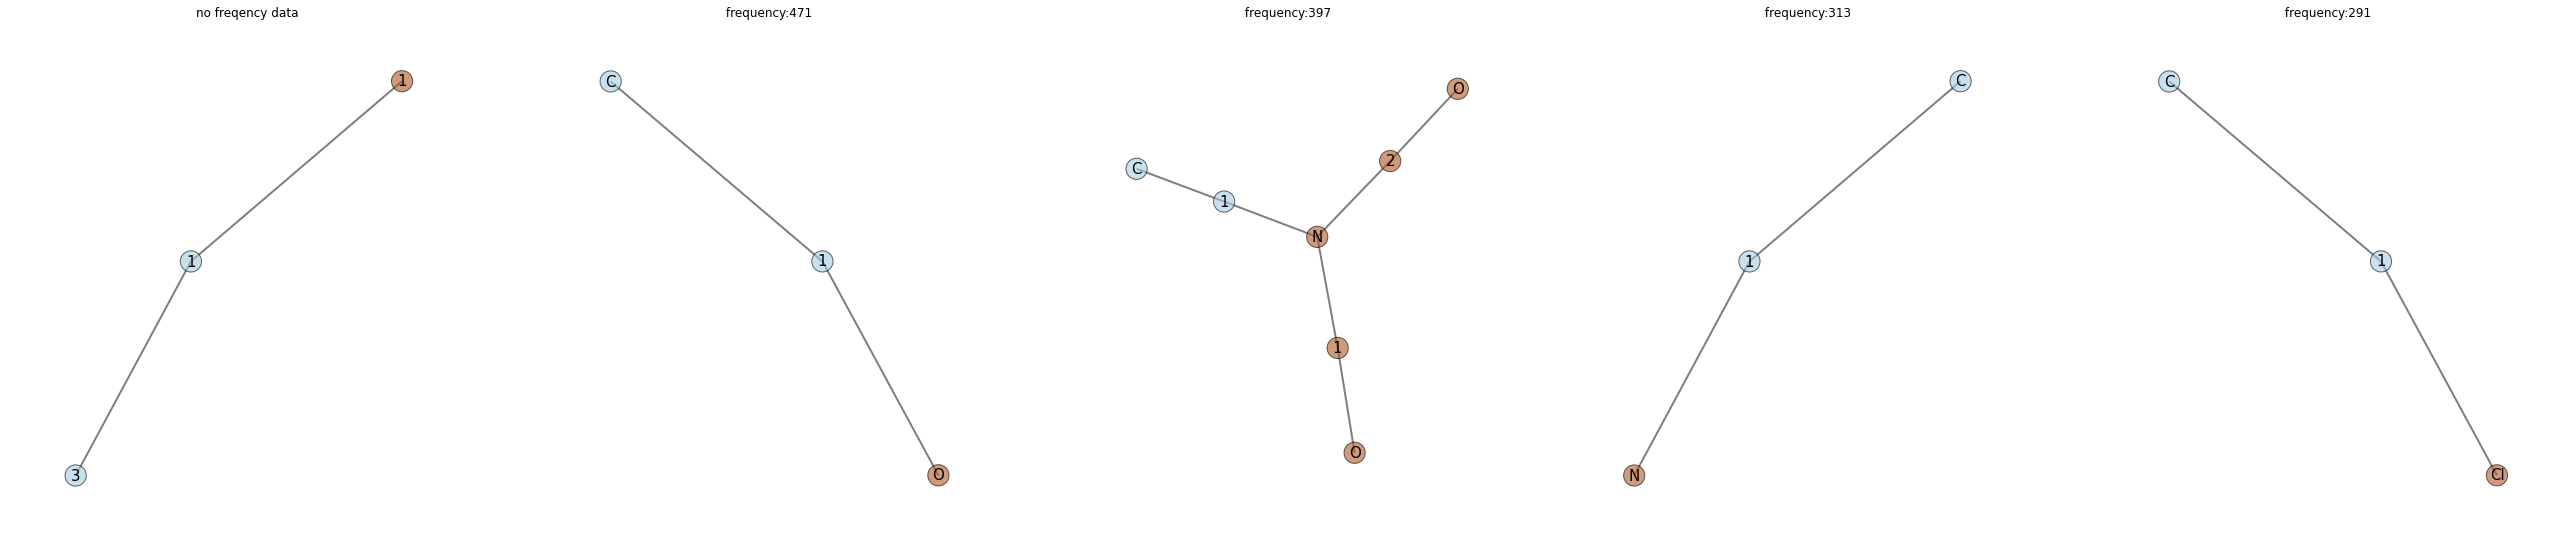

interface id: 534626 [54 options]


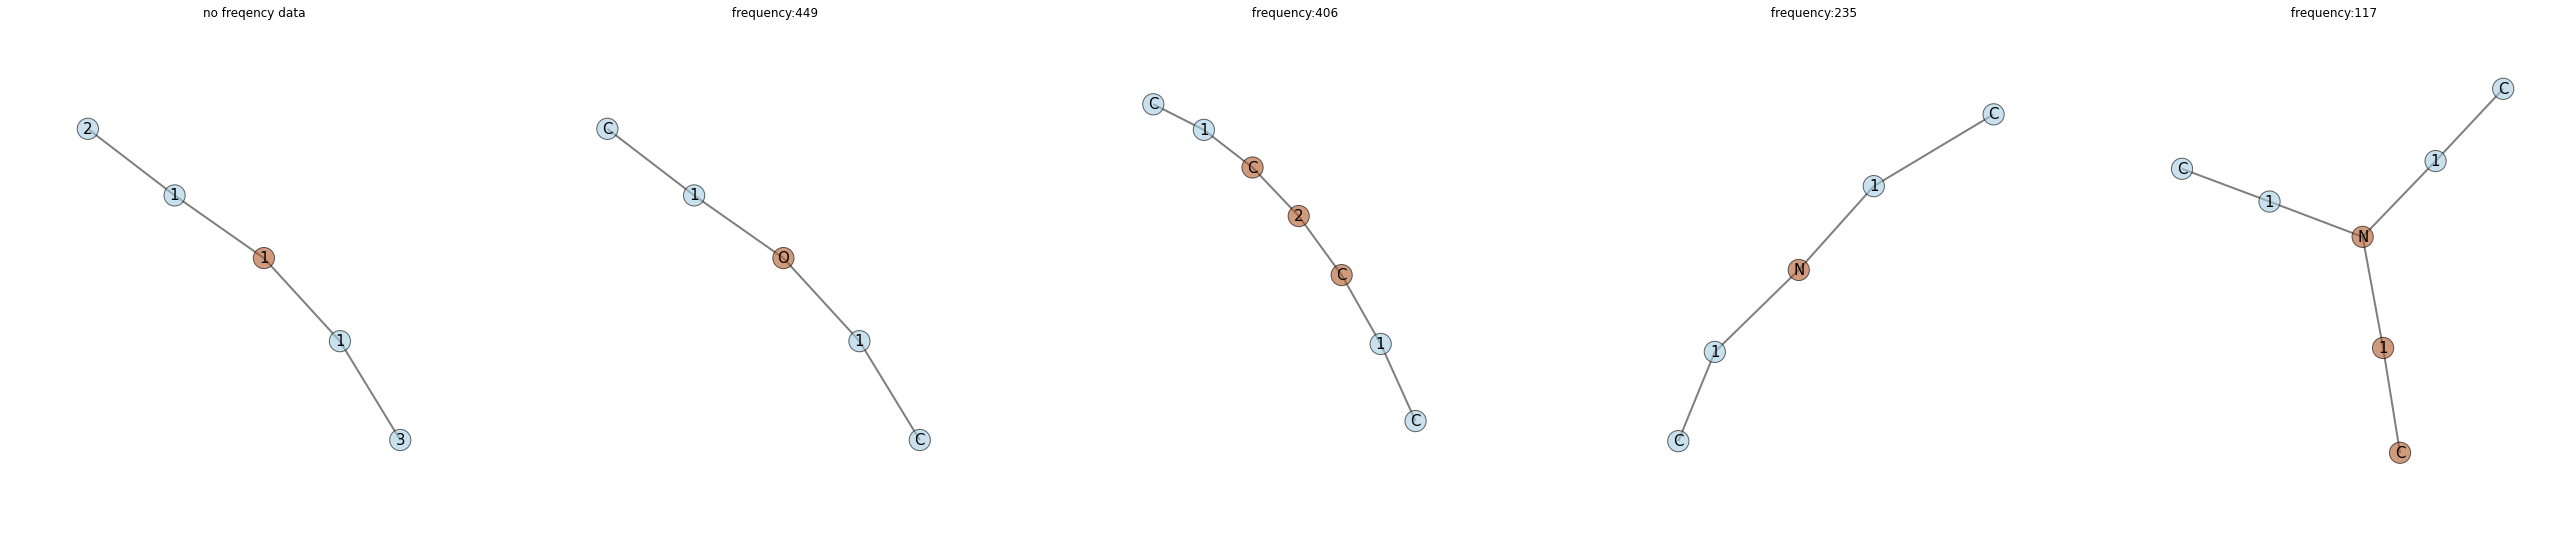

interface id: 529250 [45 options]


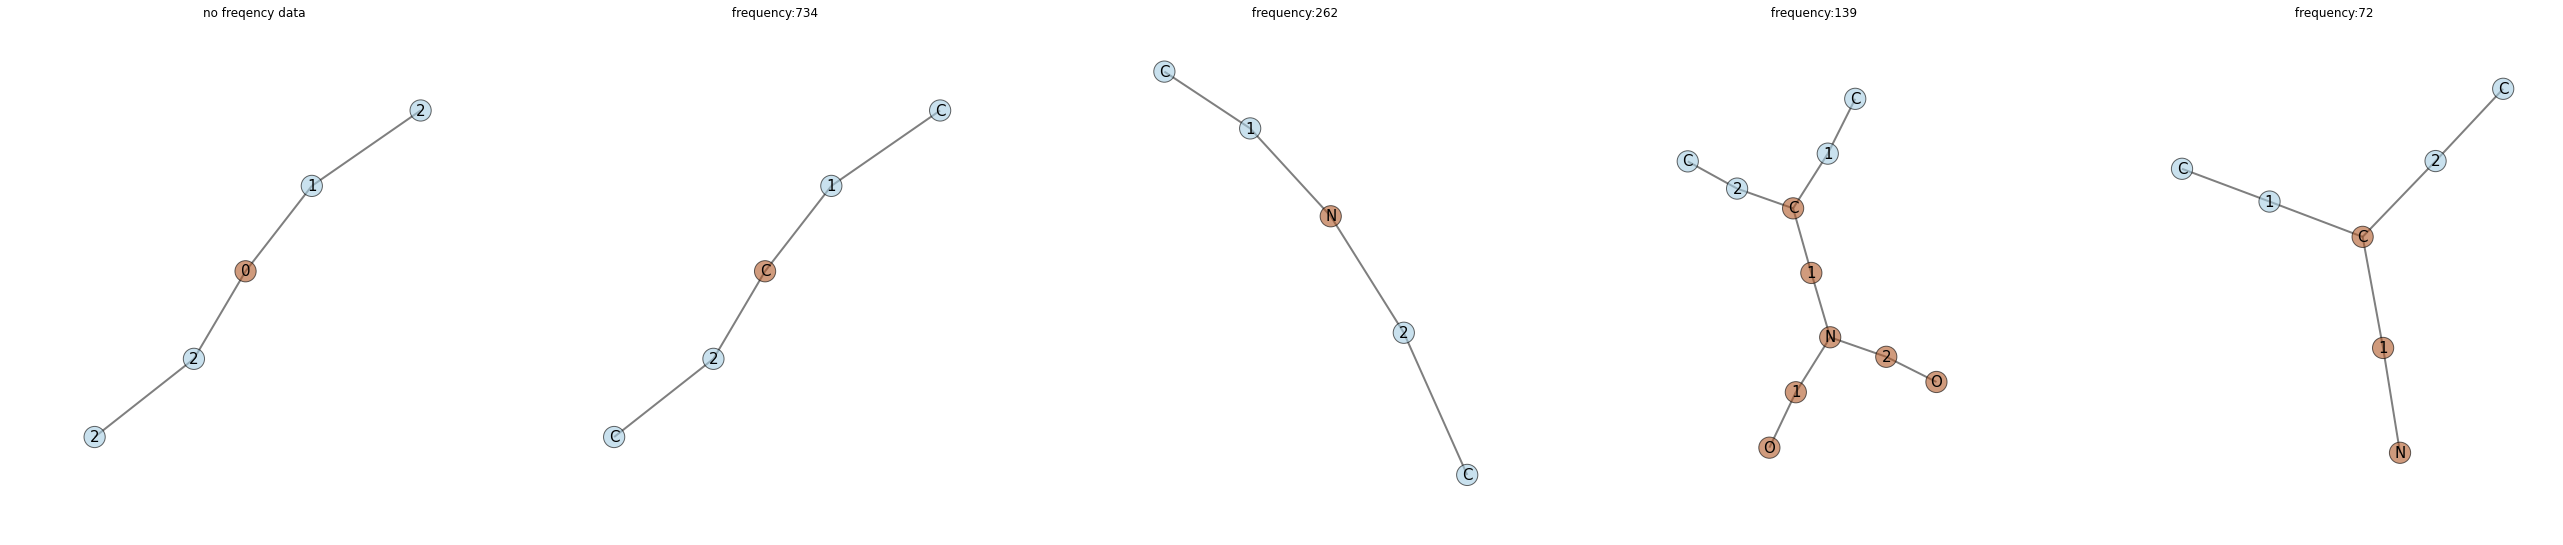

interface id: 929090 [30 options]


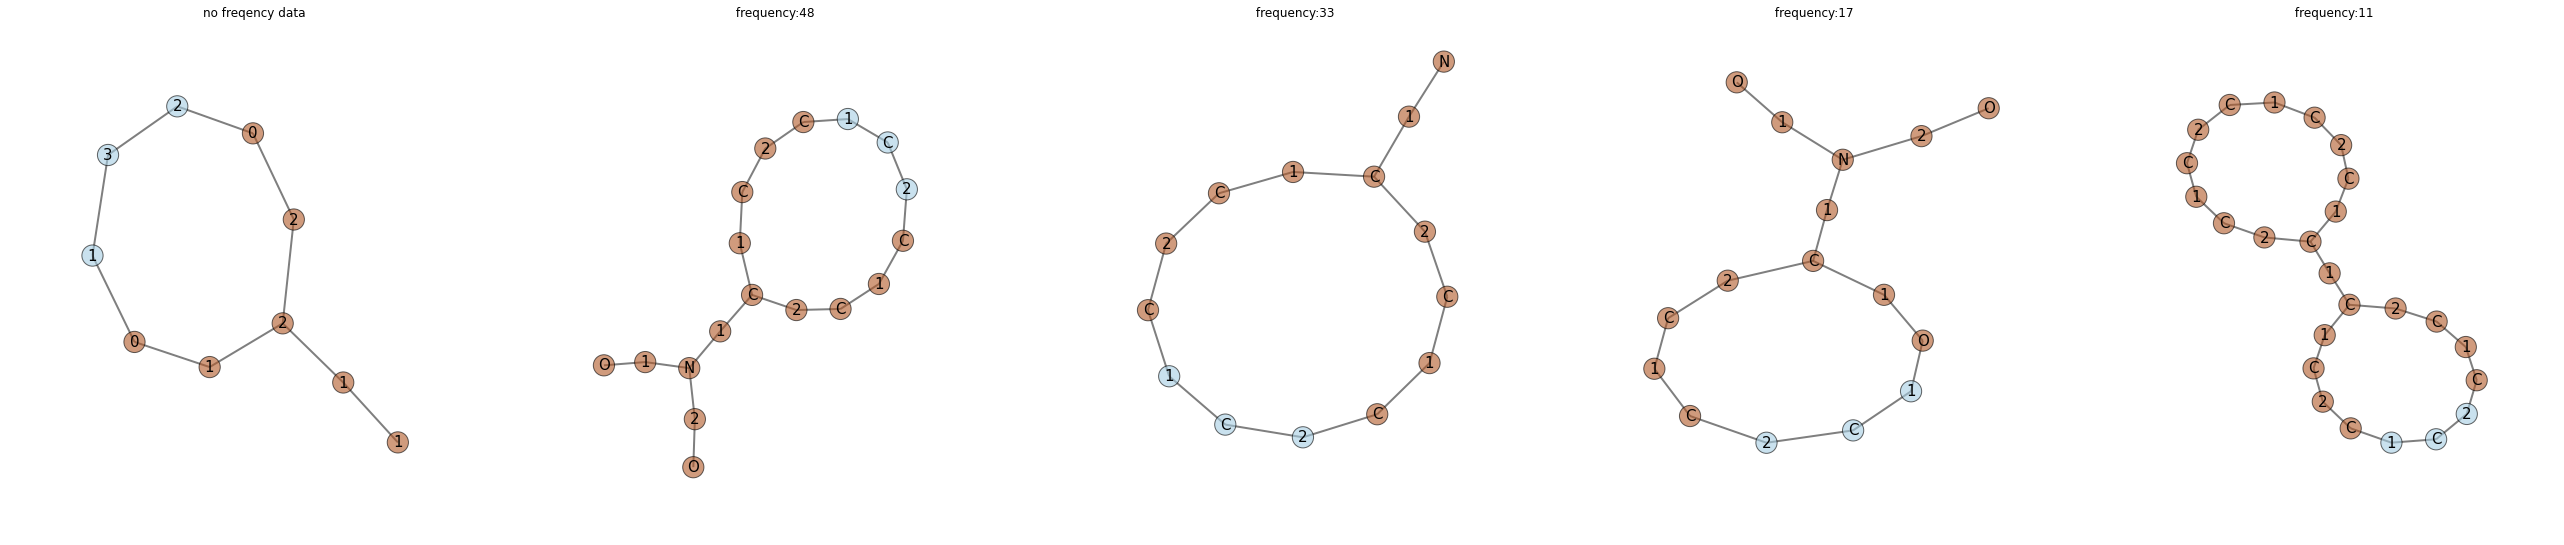

interface id: 542986 [26 options]


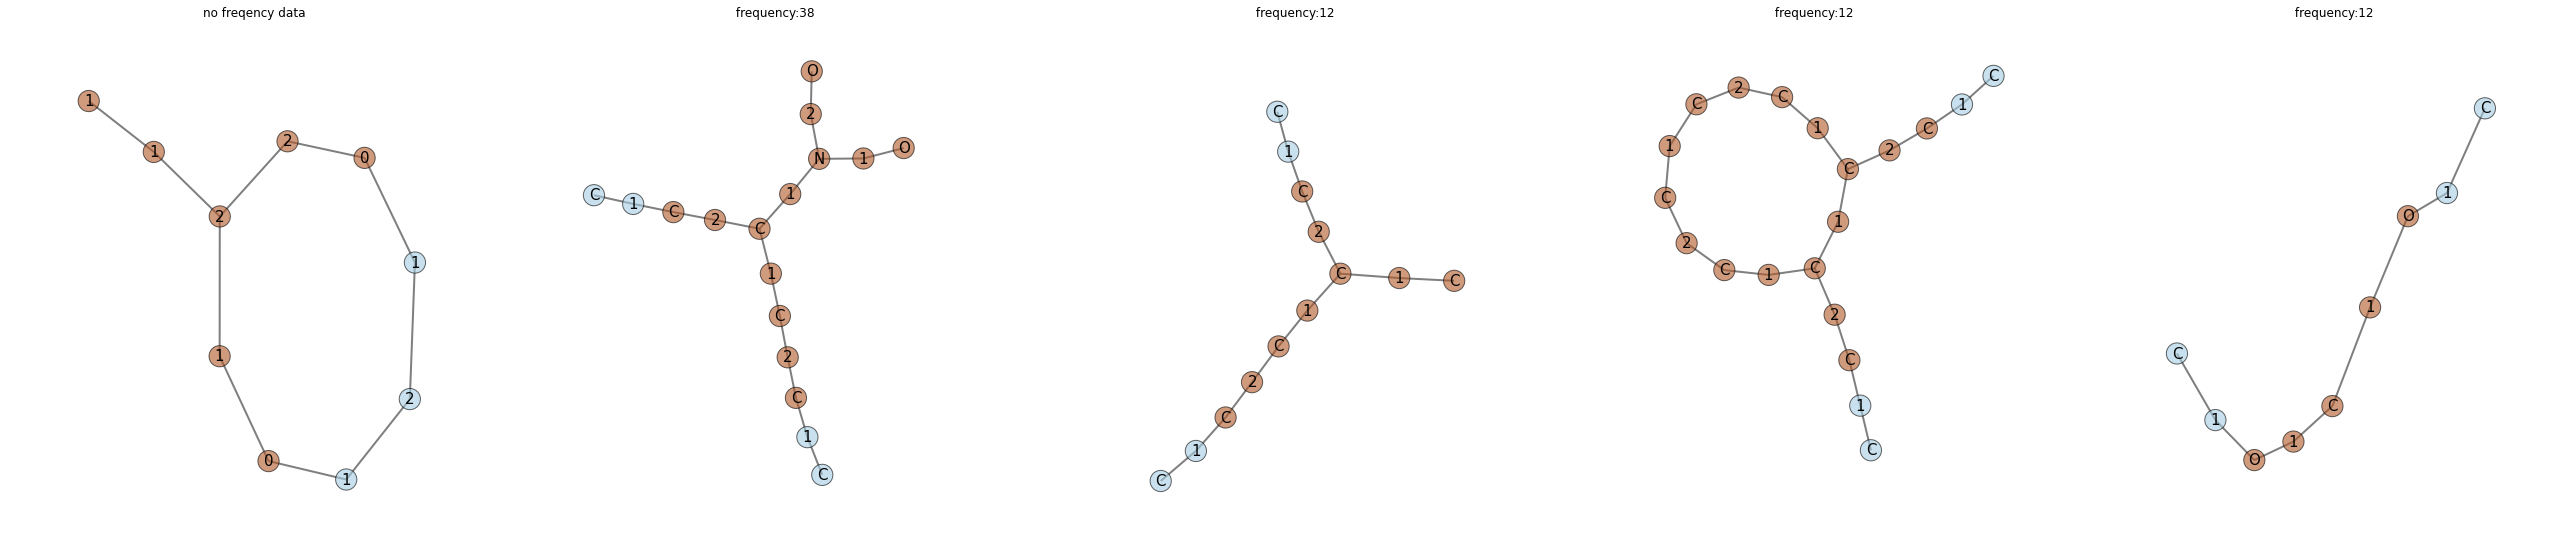

In [8]:
#draw production rules
draw.draw_grammar(sampler.lsgg.productions,n_productions=5,n_graphs_per_production=5,
                     n_graphs_per_line=5, size=9, contract=False,
                     colormap='Paired', invert_colormap=False,node_border=1,
                     vertex_alpha=0.6, edge_alpha=0.5, node_size=450, abstract_interface=True)

    

preprocessing grammar
_sample_notes: 
_sample_path_score_set: set([])
_score_list: [0.32370720722443791, 0.32370720722443791, 0.32370720722443791, 0.31661360763612079, 0.24926697154253766, 0.8557556983610406, 0.8557556983610406, 0.8557556983610406, 0.8557556983610406, 0.85497637952565109, 0.85497637952565109, 0.85425627256753744, 0.75391802504637151, 0.75391802504637151, 0.71156598789591996, 0.72669547654361, 0.79500631695098978, 0.79500631695098978, 0.78716530107982585, 0.73817398851116356, 0.73817398851116356, 0.73817398851116356, 0.78664667298097046, 0.8559412524524318, 0.8559412524524318, 0.7763484761224555, 0.80321016011186186, 0.79423298674679077, 0.8729153211773697, 0.8729153211773697, 0.85769896211756569, 0.84394717911479789, 0.84394717911479789, 0.84394717911479789, 0.84830469418161381, 0.84830469418161381, 0.80009821216387267, 0.82388273697046743, 0.83872503423159173, 0.87773517317646821, 0.87773517317646821, 0.86293129984486816, 0.86293129984486816, 0.86293129984486816, 0.86

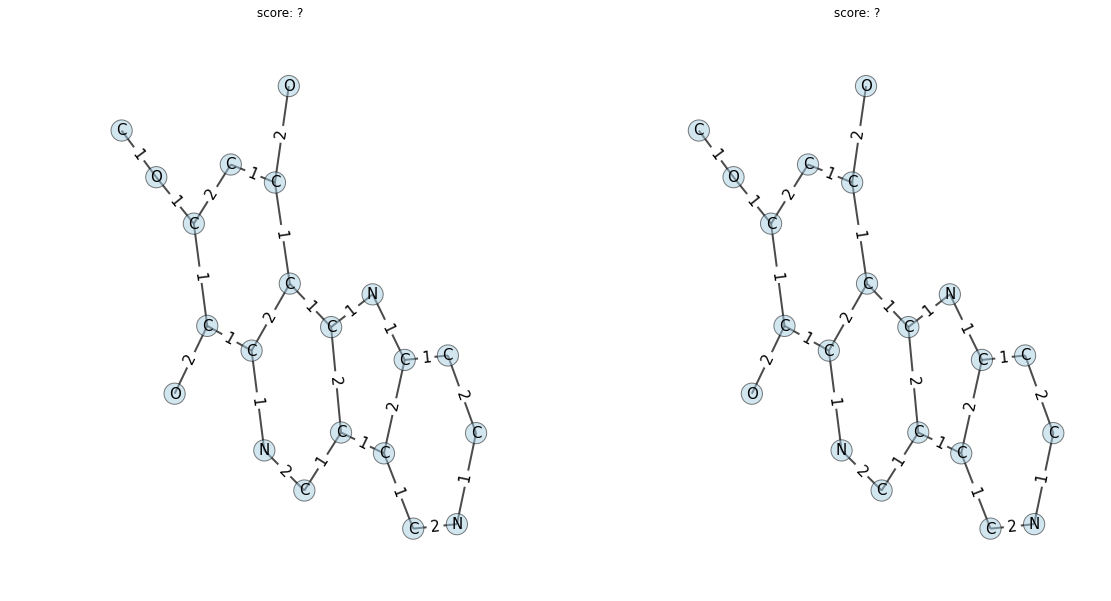

'LocalSubstitutableGraphGrammar' object has no attribute 'core_size'
Traceback (most recent call last):
  File "graphlearn/graphlearn.py", line 368, in _sample
    candidate_graph_manager = self._propose(graph_manager)
  File "graphlearn/graphlearn.py", line 533, in _propose
    graph = self._propose_graph(graphman)
  File "graphlearn/graphlearn.py", line 554, in _propose_graph
    for attempt, candidate_cip in enumerate(candidate_cips):
  File "graphlearn/graphlearn.py", line 630, in _select_cips
    values = self._core_values(cip, core_hashes, graphman.base_graph())
  File "graphlearn/graphlearn.py", line 654, in _core_values
    predicted_size = self.lsgg.core_size[core] - cip.core_nodes_count + current_size
AttributeError: 'LocalSubstitutableGraphGrammar' object has no attribute 'core_size'

Graph id: 16


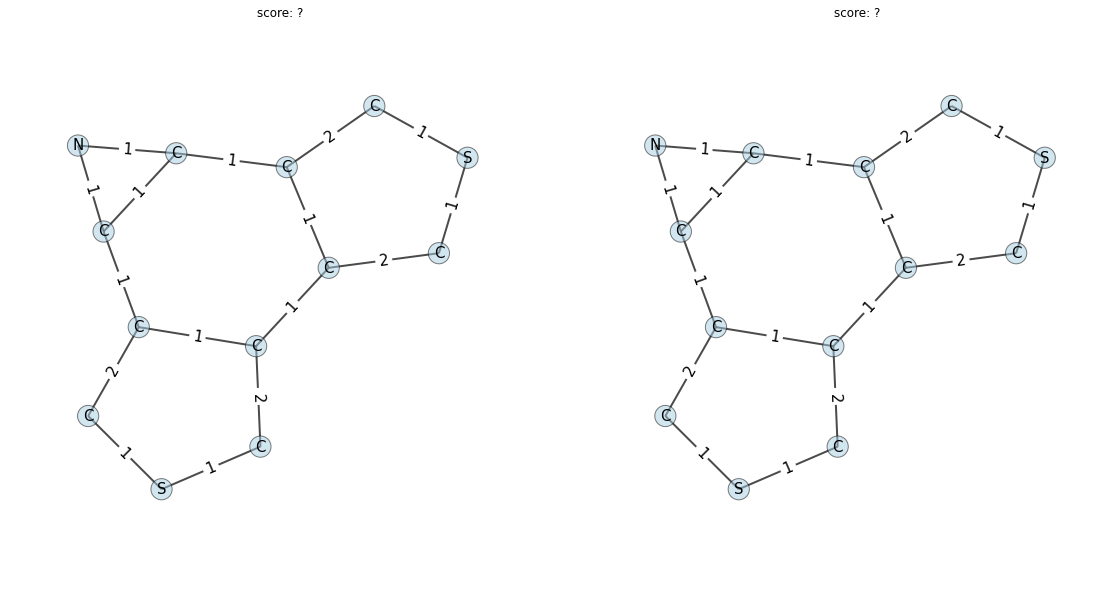

'LocalSubstitutableGraphGrammar' object has no attribute 'core_size'
Traceback (most recent call last):
  File "graphlearn/graphlearn.py", line 368, in _sample
    candidate_graph_manager = self._propose(graph_manager)
  File "graphlearn/graphlearn.py", line 533, in _propose
    graph = self._propose_graph(graphman)
  File "graphlearn/graphlearn.py", line 554, in _propose_graph
    for attempt, candidate_cip in enumerate(candidate_cips):
  File "graphlearn/graphlearn.py", line 630, in _select_cips
    values = self._core_values(cip, core_hashes, graphman.base_graph())
  File "graphlearn/graphlearn.py", line 654, in _core_values
    predicted_size = self.lsgg.core_size[core] - cip.core_nodes_count + current_size
AttributeError: 'LocalSubstitutableGraphGrammar' object has no attribute 'core_size'

Graph id: 17


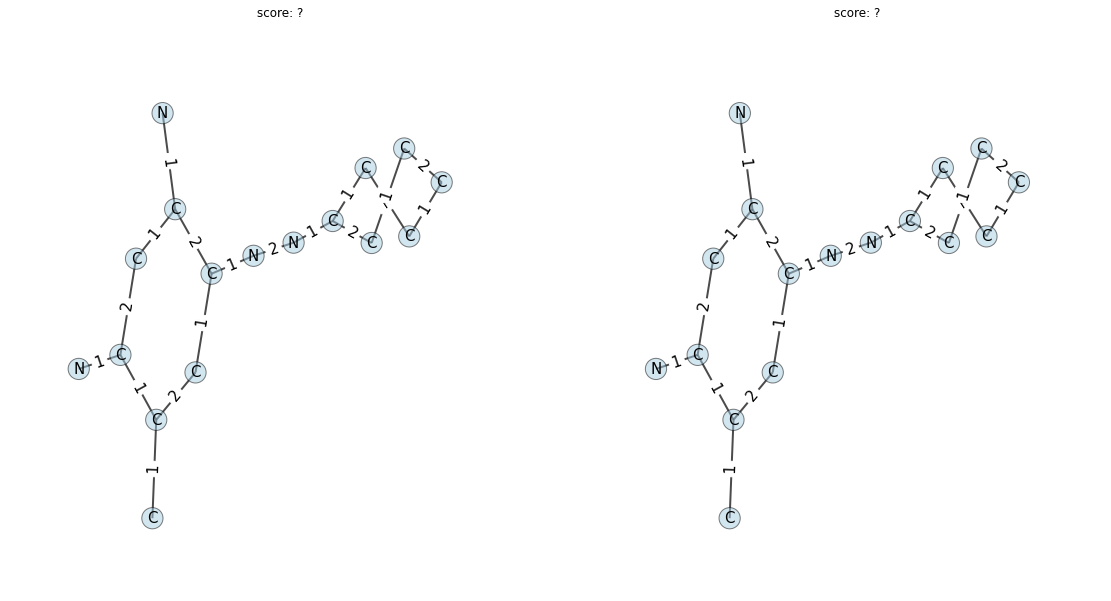

'LocalSubstitutableGraphGrammar' object has no attribute 'core_size'
Traceback (most recent call last):
  File "graphlearn/graphlearn.py", line 368, in _sample
    candidate_graph_manager = self._propose(graph_manager)
  File "graphlearn/graphlearn.py", line 533, in _propose
    graph = self._propose_graph(graphman)
  File "graphlearn/graphlearn.py", line 554, in _propose_graph
    for attempt, candidate_cip in enumerate(candidate_cips):
  File "graphlearn/graphlearn.py", line 630, in _select_cips
    values = self._core_values(cip, core_hashes, graphman.base_graph())
  File "graphlearn/graphlearn.py", line 654, in _core_values
    predicted_size = self.lsgg.core_size[core] - cip.core_nodes_count + current_size
AttributeError: 'LocalSubstitutableGraphGrammar' object has no attribute 'core_size'

Graph id: 18


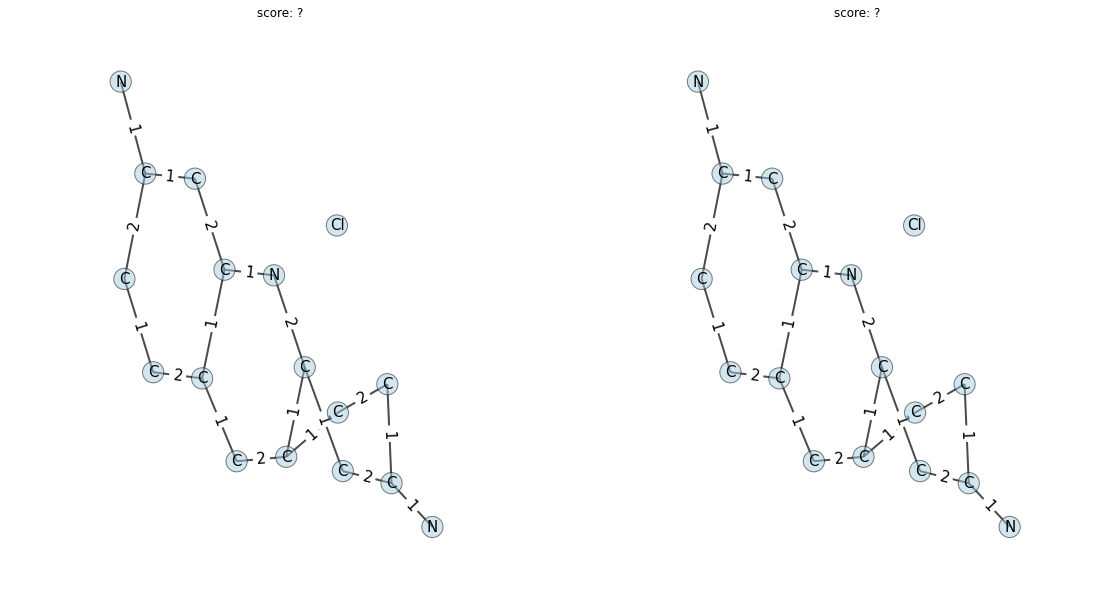

'LocalSubstitutableGraphGrammar' object has no attribute 'core_size'
Traceback (most recent call last):
  File "graphlearn/graphlearn.py", line 368, in _sample
    candidate_graph_manager = self._propose(graph_manager)
  File "graphlearn/graphlearn.py", line 533, in _propose
    graph = self._propose_graph(graphman)
  File "graphlearn/graphlearn.py", line 554, in _propose_graph
    for attempt, candidate_cip in enumerate(candidate_cips):
  File "graphlearn/graphlearn.py", line 630, in _select_cips
    values = self._core_values(cip, core_hashes, graphman.base_graph())
  File "graphlearn/graphlearn.py", line 654, in _core_values
    predicted_size = self.lsgg.core_size[core] - cip.core_nodes_count + current_size
AttributeError: 'LocalSubstitutableGraphGrammar' object has no attribute 'core_size'

Graph id: 19


KeyboardInterrupt: 

In [12]:
%%time
'''
Molecule sampling
'''
import os
os.nice(19)
import graphlearn.utils.draw as draw
import graphlearn.abstract_graphs.molecules as mole
import itertools
#sampler=mole.MolecularSampler()
#sampler.load('tmp/mole_ubergrammar.ge')
graphs = get_graphs()

id_start=15
id_end=id_start+9
graphs = itertools.islice(graphs,id_start,id_end)
n_steps=100

graphs = sampler.sample(graphs,
                        n_samples=5,
                        batch_size=1,
                        n_steps=n_steps,
                        n_jobs=1,
                        quick_skip_orig_cip=True,
                        probabilistic_core_choice=False,
                        burnin=0,
                        improving_threshold=0.5,
                        max_core_size_diff=6,
                        select_cip_max_tries=100,
                        keep_duplicates=True,
                        omit_seed=False)

 
scores=[]
ids=range(id_start,id_end)
for i,graph in enumerate(graphs):
    print 'Graph id: %d'%(ids[i])
    scores.append(graph.graph['sampling_info']['score_history'])
    path_graphs = graph.graph['sampling_info']['graphs_history']
    

    path_graphs= list(path_graphs)
    draw.graphlearn(path_graphs,
                           n_graphs_per_line=5, size=10, 
                           colormap='Paired', invert_colormap=False,node_border=0.5, vertex_color='color_level',
                           vertex_alpha=0.5, edge_alpha=0.7, node_size=450,edge_label='label',
                          headlinehook= draw.get_score_of_graph
                          )
    

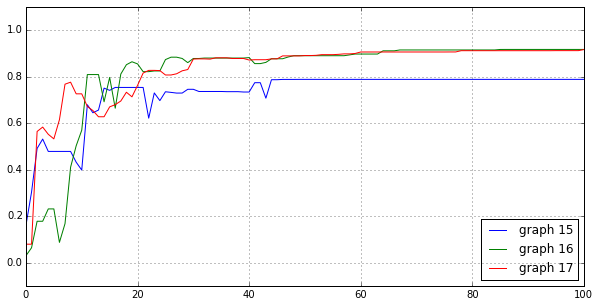

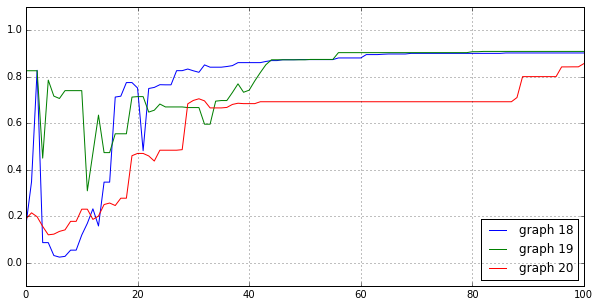

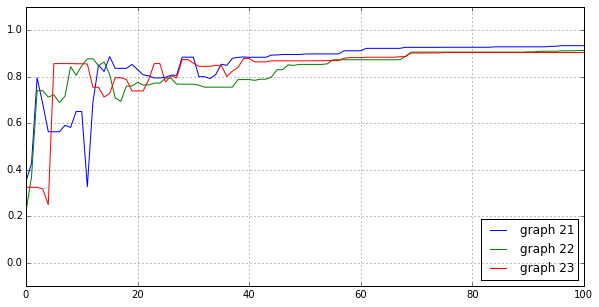

In [10]:
%matplotlib inline
from itertools import islice
import numpy as np
import matplotlib.pyplot as plt
step=1
num_graphs_per_plot=3
num_plots=np.ceil([len(scores)/num_graphs_per_plot])
for i in range(num_plots):
    plt.figure(figsize=(10,5))
    for j,score in enumerate(scores[i*num_graphs_per_plot:i*num_graphs_per_plot+num_graphs_per_plot]):
        data = list(islice(score,None, None, step))
        plt.plot(data, label='graph %d'%(j+i*num_graphs_per_plot+id_start))
    plt.legend(loc='lower right')
    plt.grid()
    plt.ylim(-0.1,1.1)
    plt.show()

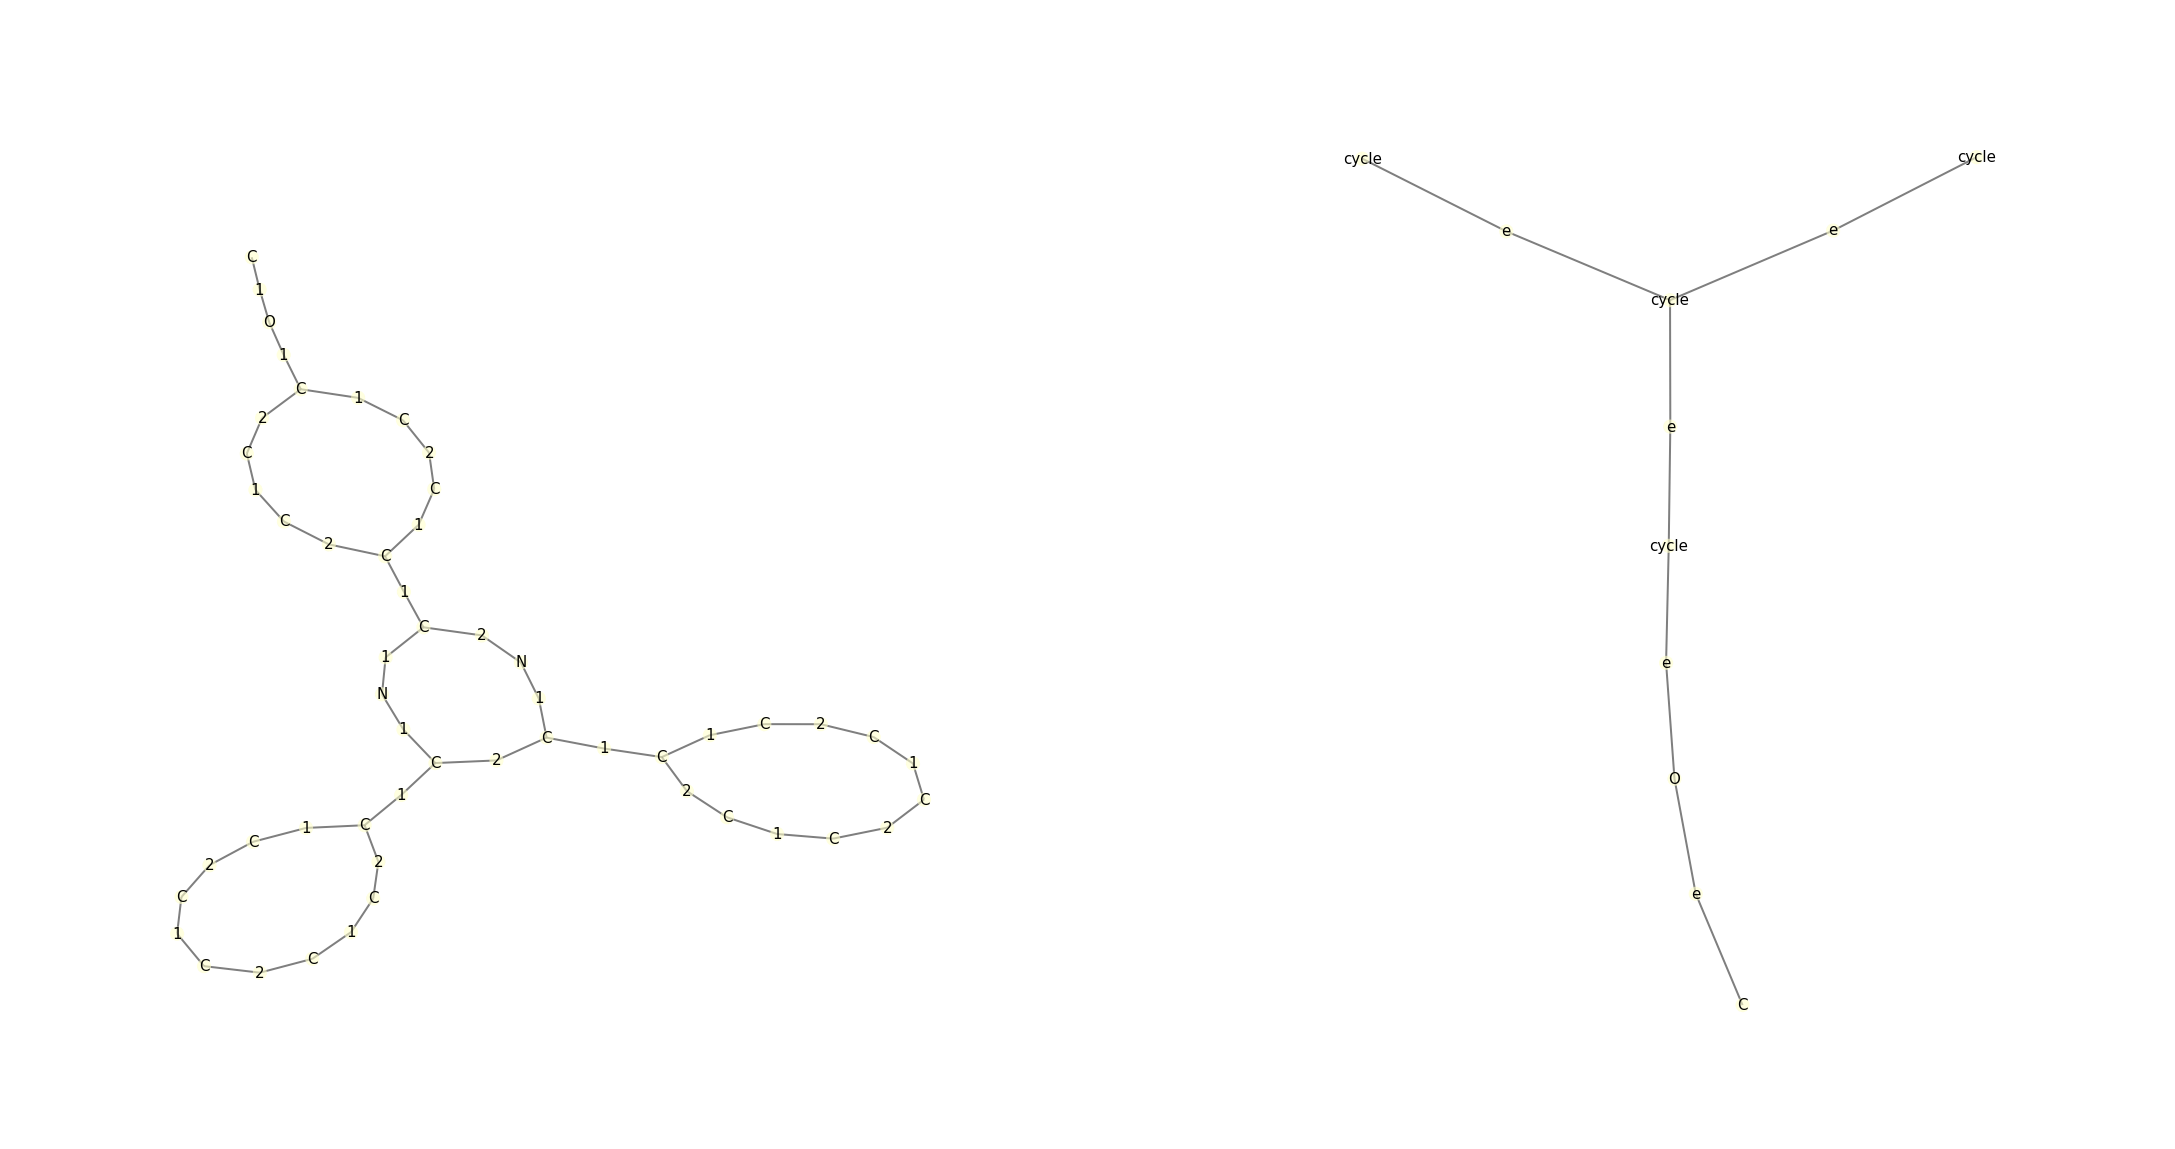

KeyError: 'weight'

In [11]:
import graphlearn.abstract_graphs.molecules as mole
from graphlearn.utils import draw
from eden.graph import Vectorizer
v=Vectorizer()
from graphlearn.abstract_graphs.molecules import node_to_cycle
import networkx as nx
import eden

def make_abstract(graph):
    '''
    make sure this is not expanded
    '''
    # prepare fast hash function
    def fhash(stuff):
        return eden.fast_hash(stuff, 2 ** 20 - 1)
    
    
    # all nodes get their cycle calculated
    for n, d in graph.nodes(data=True):
        d['cycle'] = list(node_to_cycle(graph, n))
        d['cycle'].sort()
        #if 'parent'in d:
        #    d.pop('parent')
            

    
    # make sure most of the abstract nodes are created.
    abstract_graph = nx.Graph()
    for n, d in graph.nodes(data=True):
        cyclash = fhash(d['cycle'])
        if cyclash not in abstract_graph.node:
            abstract_graph.add_node(cyclash)
            abstract_graph.node[cyclash]['contracted'] = set(d['cycle'])
            abstract_graph.node[cyclash]['node'] = True
            # it is possible that a node belongs to more than 1 cycle, so...
            # each node gets parents
            for e in d['cycle']:
                node = graph.node[e]
                if 'parent' not in node:
                    node['parent'] = set()
                node['parent'].add(cyclash)


    
    #  HERE THE ACTUAL ABSTRACTION BEGINS

    # connect nodes in the abstract graph
    get_element = lambda x: list(x)[0]


    
    # FOR ALL ABSTRACT NODES
    for n, d in abstract_graph.nodes(data=True):
        # FIND A LABEL
        if len(d['contracted']) > 1:
            labels = [ord(graph.node[childid]['label']) for childid in d['contracted']]
            labels.sort()
            d['label'] = "cycle" #fhash(labels)

        else:
            d['label'] = graph.node[get_element(d['contracted'])]['label']

      
 
        # THEN LOOK AT ALL CONTRACTED NODES TO FIND OUT WHAT CONNECTION WE HAVE TO OUR NEIGHBORS
        for base_node in d['contracted']:
            base_neighbors = graph.neighbors(base_node)
            # for all the neighbors
            for neigh in base_neighbors:
                
                
                # find out if we have to build a connector node
                if len(graph.node[neigh]['cycle']) > 1 and len(d['contracted']) > 1:

                    for other in graph.node[neigh]['parent']:
                        if other != n:
                            l = [other, n]
                            l.sort()
                            connector = fhash(l)
                            
                            
                            shared_nodes = abstract_graph.node[other]['contracted'] & d['contracted']
                            if len(shared_nodes)==0:
                                label='e'
                            else:
                                labels = [ord(graph.node[sid]['label']) for sid in shared_nodes]
                                labels.sort()
                                share_hash = fhash(labels)
                                label='share:'+str(share_hash)
                            abstract_graph.add_edge(other,n,label=label)
                            '''
                            if connector not in abstract_graph.node:
                                # we need to consider making the edge the actual intersect of the two...

                                abstract_graph.add_node(connector)
                                abstract_graph.node[connector]['edge'] = True

                                # abstract_graph.node[connector]['label']='edge'
                                shared_nodes = abstract_graph.node[other]['contracted'] & d['contracted']
                                labels = [ord(graph.node[sid]['label']) for sid in shared_nodes]
                                labels.sort()
                                share_hash = fhash(labels)


                                abstract_graph.node[connector]['label'] = "shared" + str(share_hash)

                                abstract_graph.add_edge(other, connector)
                                abstract_graph.add_edge(connector, n)
                            '''
                else:
                    for e in graph.node[neigh]['parent']:
                        abstract_graph.add_edge(n, e, label='e')
    return abstract_graph




def graphor(base,abstr,nested=True):
    g= nx.disjoint_union(base, abstr)
    node_id= len(g)

    for n,d in g.nodes(data=True):
        if 'contracted' in d and 'edge' not in d:
            for e in d['contracted']:
                if 'edge' not in g.node[e]:
                    # we want an edge from n to e
                    g.add_node(node_id,edge=True,label='e')
                    g.add_edge( n, node_id, nesting=True)
                    g.add_edge( node_id, e, nesting=True)
                    #g.add_edge( n, e, nesting=True)
                    node_id+=1
    return g
    


gr=get_graphs()
for i in range(1):
    g=gr.next()
    ab=make_abstract(g)
    
    g=v._edge_to_vertex_transform(g)
    ab=v._edge_to_vertex_transform(ab)
    zz=graphor(g,ab)
    draw.graphlearn([g,ab], size=20)
    v.transform_single(zz)

    


In [3]:
import random
l=[1,2,3,4]
random.shuffle(l)

In [5]:
5/2


2